# Group X, Names, project

## Structure


    Imports
    Load Data
    
    Pre-process 
    
    Final dataframe, displayed
        -sub dataframes established for Model evaluation comparison
        
    EDA
        - Explore the relationships between the variables
        - Explore the relationships between party and incumbency success and the features
        - visualiations
  
    Walkthrough of models attempted and showing of results exploration
        -score reporting  (can use acc., f1, confusion_matrix, important variables indicated if possible)
        -visualization comparing various model results
        -pick best/most mature/informed version of model 
         for analysis (best performing model)

    Final model that performed the best, thorough score analysis
        -clear metrics/explanation for why this approach is interesting/fruitful
        -visualization to include in conclusion
        -perhaps comparison to trivial model (vote with incumbent)
        -build to set up write-up conclusion

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
import statsmodels.api as sm
from statsmodels.api import OLS

import tensorflow as tf


## Load Data

In [2]:
#Load Data


#States

states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE','DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

# House election Harvard Dataverse https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/IG0UN2
district_results = pd.read_csv('1976-2018-house.csv', header=0,encoding = 'unicode_escape')
district_results['candidatevotes'] = district_results['candidatevotes'].str.replace(',', '')
district_results['candidatevotes'] = district_results['candidatevotes'].astype(int)

# 2016 Election Results https://transition.fec.gov/general/FederalElections2016.shtml
pres_gen_results_2016 = pd.read_csv('2016 Pres General Results-Table 1.csv', header=0,encoding = 'unicode_escape')
sen_results_2016 = pd.read_csv('2016 US Senate Results by State-Table 1.csv', header=0,encoding = 'unicode_escape')
house_results_2016 = pd.read_csv('2016 US House Results by State-Table 1.csv', header=0,encoding = 'unicode_escape')

#12/14 State Results
Election_2012 = district_results.loc[district_results['year'] == 2012]
Election_2014 = district_results.loc[district_results['year'] == 2014]

#16/18 State Results 
Election_2016 = district_results.loc[district_results['year'] == 2016]
Election_2018 = district_results.loc[district_results['year'] == 2018]

#Sports Data 
sports_results_all = pd.read_csv('sports_data.csv')

#Economic Indicators

#Real GDP per capita by state by year (2018 set)
rGDP_pc_2015 = pd.read_csv('Real_GDP_pc/2015_rGDP_edit.csv')
rGDP_pc_2016 = pd.read_csv('Real_GDP_pc/2016_rGDP_edit.csv')
rGDP_pc_2017 = pd.read_csv('Real_GDP_pc/2017_rGDP_edit.csv')

#Real GDP per capita by state by year (2014 set)
rGDP_pc_2011 = pd.read_csv('Real_GDP_pc/2011_rGDP_edit.csv')
rGDP_pc_2012 = pd.read_csv('Real_GDP_pc/2012_rGDP_edit.csv')
rGDP_pc_2013 = pd.read_csv('Real_GDP_pc/2013_rGDP_edit.csv')


#Unemployment delta by state, 2016--2018
## US national delta = -1%
unemp_delta_df = pd.read_csv('2014_2018_unemp_oneyr_delta.csv')
rGDP_pc_2015.columns = ['state','2015_GDP']
economic_indicators = rGDP_pc_2015.copy()
economic_indicators['2016_GDP'] = rGDP_pc_2016['value']
economic_indicators['2017_GDP'] = rGDP_pc_2017['value']
economic_indicators['2011_GDP'] = rGDP_pc_2011['value']
economic_indicators['2012_GDP'] = rGDP_pc_2012['value']
economic_indicators['2013_GDP'] = rGDP_pc_2013['value']

economic_indicators['state'] = states
# economic_indicators = economic_indicators.join(unemp_delta_df, on = 'state')
economic_indicators = economic_indicators.join(unemp_delta_df.set_index('state'), on='state', how='inner')


economic_indicators['GDP_growth_2017'] = (economic_indicators['2017_GDP']-economic_indicators['2016_GDP'])/ economic_indicators['2017_GDP']
economic_indicators['GDP_growth_2013'] = (economic_indicators['2013_GDP']-economic_indicators['2012_GDP'])/ economic_indicators['2013_GDP']


##### District Data 2014

# district education
district_educ_14 = pd.read_csv('District_Education.csv', header=0,encoding = 'unicode_escape')
district_educ_14 = district_educ_14.drop([district_educ_14.index[87], district_educ_14.index[436]])
bach_14 = district_educ_14["Total; Estimate; Percent bachelor's degree or higher"]
hs_14 = district_educ_14["Total; Estimate; Percent high school graduate or higher"]
dist_names_14 = district_educ_14['Geography']

# district poverty
district_pov_14 = pd.read_csv('District_Poverty.csv', header=0,encoding = 'unicode_escape')
district_pov_14 = district_pov_14.drop([district_pov_14.index[87], district_pov_14.index[436]])
pov_14 = district_pov_14['Percent below poverty level; Estimate; Population for whom poverty status is determined']

# district age gropus
district_age_14 = pd.read_csv('District_Age_Group.csv', header=0,encoding = 'unicode_escape')
district_age_14 = district_age_14.drop([district_age_14.index[87], district_age_14.index[436]])

## district income
district_income_14 = pd.read_csv('Household_Income.csv', header=0,encoding = 'unicode_escape')
district_income_14 = district_income_14.drop([district_income_14.index[87], district_income_14.index[436]])
median_income_14 = district_income_14['Households; Estimate; Median income (dollars)'] 

###### District Data 2017 for 2018 dataframe
# district education

# extra things in district data, removing them 
district_educ_18 = pd.read_csv('Education_2017.csv', header=0,encoding = 'unicode_escape')
district_educ_18 = district_educ_18.drop([district_educ_18.index[87], district_educ_18.index[436]])
bach_18 = district_educ_18["Percent; Estimate; Percent bachelor's degree or higher"]
hs_18 = district_educ_18["Percent; Estimate; Percent high school graduate or higher"]
dist_names_18 = district_educ_18['Geography']

# district poverty
district_pov_18 = pd.read_csv('Poverty_2017.csv', header=0,encoding = 'unicode_escape')
district_pov_18 = district_pov_18.drop([district_pov_18.index[87], district_pov_18.index[436]])
pov_18 = district_pov_18['Percent below poverty level; Estimate; Population for whom poverty status is determined']

# district income
district_income_18 = pd.read_csv('Income_2017.csv', header=0,encoding = 'unicode_escape')
district_income_18 = district_income_18.drop([district_income_18.index[87], district_income_18.index[436]])
median_income_18 = district_income_18['Households; Estimate; Median income (dollars)'] 


In [3]:
import glob

# Load Census District Data

filenames = glob.glob('District Data' + "/*.csv")


dfs = {}

filenames.sort()
i = 0 
for filename in filenames:
    dfs['state' + str(i)] = pd.read_csv(filename)
    i = i + 1

## Process Data & Build Data Frames

In [4]:
agg_dist_14 = pd.DataFrame(dist_names_14)
agg_dist_14.insert(1, "Percent high school", hs_14)
agg_dist_14.insert(2, "Percent bachelor degrees", bach_14)
agg_dist_14.insert(3, "Below Poverty Line", pov_14)
agg_dist_14.insert(4, "Median Income", median_income_14)

agg_dist_18 = pd.DataFrame(dist_names_18)
agg_dist_18.insert(1, "Percent high school", hs_18)
agg_dist_18.insert(2, "Percent bachelor degrees", bach_18)
agg_dist_18.insert(3, "Below Poverty Line", pov_18)
agg_dist_18.insert(4, "Median Income", median_income_18)

In [5]:
agg_dist_18.head()

,Geography,Percent high school,Percent bachelor degrees,Below Poverty Line,Median Income
0,"Congressional District 1 (115th Congress), Ala...",87.0,24.0,18.0,46449
1,"Congressional District 2 (115th Congress), Ala...",84.1,22.1,18.8,44765
2,"Congressional District 3 (115th Congress), Ala...",84.0,21.5,18.7,44725
3,"Congressional District 4 (115th Congress), Ala...",80.9,16.9,18.5,41822
4,"Congressional District 5 (115th Congress), Ala...",87.1,30.8,15.0,52874


In [6]:
agg_dist_14.head()

,Geography,Percent high school,Percent bachelor degrees,Below Poverty Line,Median Income
0,"Congressional District 1 (114th Congress), Ala...",85.4,22.4,18.8,44302
1,"Congressional District 2 (114th Congress), Ala...",83.0,21.3,19.2,43205
2,"Congressional District 3 (114th Congress), Ala...",82.0,20.1,21.0,41037
3,"Congressional District 4 (114th Congress), Ala...",79.2,15.5,19.2,39316
4,"Congressional District 5 (114th Congress), Ala...",85.7,29.2,14.9,50264


In [7]:
##### 2014 Set  (includes 2012,2014)
#Get winners for each district 
district_winners_2012 = pd.DataFrame()
for state in states : 
    temp = Election_2012.loc[Election_2012['state_po'] == state]
    #number of districts
    districts_number = temp['district'].max()
    counter = 0
    while counter <= districts_number : 
        district = temp.loc[temp['district'] == counter]
        winner = pd.DataFrame(district.loc[district['candidatevotes'] == district['candidatevotes'].max()])
        district_winners_2012 = district_winners_2012.append(winner)
        counter = counter + 1 

#will be the 'result'
#  Dataframe to add district predictors 
district_winners_2014 = pd.DataFrame()
for state in states : 
    temp = Election_2014.loc[Election_2014['state_po'] == state]
    #number of districts
    districts_number = temp['district'].max()
    counter = 0
    while counter <= districts_number : 
        district = temp.loc[temp['district'] == counter]
        winner = pd.DataFrame(district.loc[district['candidatevotes'] == district['candidatevotes'].max()])
        district_winners_2014 = district_winners_2014.append(winner)
        counter = counter + 1 
        

###### 2018 Set (includes 2016,2018)
district_winners_2016 = pd.DataFrame()
for state in states : 
    temp = Election_2016.loc[Election_2016['state_po'] == state]
    #number of districts
    districts_number = temp['district'].max()
    counter = 0
    while counter <= districts_number : 
        district = temp.loc[temp['district'] == counter]
        winner = pd.DataFrame(district.loc[district['candidatevotes'] == district['candidatevotes'].max()])
        district_winners_2016 = district_winners_2016.append(winner)
        counter = counter + 1 


district_winners_2018 = pd.DataFrame()
for state in states : 
    temp = Election_2018.loc[Election_2018['state_po'] == state]
    #number of districts
    districts_number = temp['district'].max()
    counter = 0
    while counter <= districts_number : 
        district = temp.loc[temp['district'] == counter]
        winner = pd.DataFrame(district.loc[district['candidatevotes'] == district['candidatevotes'].max()])
        district_winners_2018 = district_winners_2018.append(winner)
        counter = counter + 1 
        

In [8]:
len(district_winners_2018)

435

In [9]:
len(district_winners_2018.state_po.value_counts())

50

In [10]:
# Classify based on party 

for district in district_winners_2012.iterrows():
    # May be able to use the vote count to assign the correct value back to the original dataframe, 
    # only two winners shared an exact vote count so only 1 collision must be handled
    if district[1]['party'] == 'republican' : 
        district_winners_2012.loc[district[0],'class'] = 0
    elif district[1]['party'] == 'democrat' :
        district_winners_2012.loc[district[0],'class'] = 1
    else:
        district_winners_2012.loc[district[0],'class'] = 2
        
for district in district_winners_2014.iterrows():
    # May be able to use the vote count to assign the correct value back to the original dataframe, 
    # only two winners shared an exact vote count so only 1 collision must be handled
    if district[1]['party'] == 'republican' : 
        district_winners_2014.loc[district[0],'class'] = 0
    elif district[1]['party'] == 'democrat' :
        district_winners_2014.loc[district[0],'class'] = 1
    else:
        district_winners_2014.loc[district[0],'class'] = 2
    
for district in district_winners_2016.iterrows():
    # May be able to use the vote count to assign the correct value back to the original dataframe, 
    # only two winners shared an exact vote count so only 1 collision must be handled
    if district[1]['party'] == 'republican' : 
        district_winners_2016.loc[district[0],'class'] = 0
    elif district[1]['party'] == 'democrat' :
        district_winners_2016.loc[district[0],'class'] = 1
    else:
        district_winners_2016.loc[district[0],'class'] = 2

for district in district_winners_2018.iterrows():
    # May be able to use the vote count to assign the correct value back to the original dataframe, 
    # only two winners shared an exact vote count so only 1 collision must be handled
    if district[1]['party'] == 'republican' : 
        district_winners_2018.loc[district[0],'class'] = 0
    elif district[1]['party'] == 'democrat' :
        district_winners_2018.loc[district[0],'class'] = 1
    else:
        district_winners_2018.loc[district[0],'class'] = 2

In [11]:
# Mean statistic across all districts for each state  
# Handled differently because data format likely ----
# this Takes district data for Poverty, Bachelors, HSdegree and averages
# it to produce a single value for a State-level dataframe

percentage_below_poverty_line = []
percent_bachelor = []
percent_hs = []
for state in dfs:
    num_cols = len(dfs[state].columns)
    stats_pl = dfs[state][dfs[state]['Subject'] == 'Percentage of Families and People Whose Income in the Past 12 Months is Below the Poverty Level'].iloc[0:1,]
    stats_ba = dfs[state][dfs[state]['Title'] == "Percent bachelor's degree or higher"]
    stats_hs = dfs[state][dfs[state]['Title'] == "Percent high school graduate or higher"]
    pl_mean_sum = 0
    hs_mean_sum = 0
    ba_mean_sum = 0
    for col in range(num_cols):
        if col < 3:
            continue
        elif (col % 2) != 0:
            pl_mean_sum += float(stats_pl.iloc[:,col].values[0])
            hs_mean_sum += float(stats_hs.iloc[:,col].values[0])
            ba_mean_sum += float(stats_ba.iloc[:,col].values[0])
        else:
            continue
            
    pl_mean = pl_mean_sum / ((num_cols - 3)/2)
    percentage_below_poverty_line.append(pl_mean)
    
    hs_mean = hs_mean_sum / ((num_cols - 3)/2)
    
    ba_mean = ba_mean_sum / ((num_cols - 3)/2)
    
    percent_hs.append(hs_mean)
    percent_bachelor.append(ba_mean)

In [12]:
# State Data for 2014

#education data
district_educ_14_st = pd.read_csv('district14/Education Attainment edited.csv', header=0,encoding = 'unicode_escape')
bach_14_st = district_educ_14_st["Total; Estimate; Percent bachelor's degree or higher"]
hs_14_st = district_educ_14_st["Total; Estimate; Percent high school graduate or higher"]
state_names_14_st = district_educ_14_st['Geography']

# poverty data
pov_14_st = pd.read_csv('district14/District Poverty.csv')
poverty_14_st = pov_14_st['Percent below poverty level; Estimate; Population for whom poverty status is determined']

dist14 = pd.DataFrame(state_names_14_st)
dist14.insert(1, "hs14", hs_14_st/100)
dist14.insert(2, "bachelors14", bach_14_st/100)
dist14.insert(3, "poverty14", poverty_14_st/100)
dist14 = dist14[:51]
dist14.insert(4, 'state', states)


In [13]:
#sports results already had 14,18 full athletic records
# This block adds 2018 State Data

sports_results_all['hs18'] = pd.Series(percent_hs)/100
sports_results_all['bachelors18'] = pd.Series(percent_bachelor)/100
sports_results_all['poverty18'] = pd.Series(percentage_below_poverty_line)/100

In [14]:
sports_results_all = sports_results_all.join(dist14.set_index('state'), on='State').drop('Geography', axis=1)

In [15]:
sports_results_all.shape

(51, 15)

In [16]:
economic_indicators18 = economic_indicators[['state', '2015_GDP', '2016_GDP', '2017_GDP','2018_oneyr_unemp_delta', 'GDP_growth_2017']]
economic_indicators14 = economic_indicators[['state', '2011_GDP', '2012_GDP', '2013_GDP','2014_oneyr_unemp_delta', 'GDP_growth_2013']]
sports_results18 = sports_results_all[['State','cfb 18', 'nfl 18', 'nba 18', 'cbb 18', 'poverty18', 'bachelors18', 'hs18']]
sports_results14 = sports_results_all[['State','cfb 14', 'nfl 14', 'nba 14', 'cbb 14', 'poverty14', 'bachelors14', 'hs14']]

In [17]:
economic_indicators18.head()

,state,2015_GDP,2016_GDP,2017_GDP,2018_oneyr_unemp_delta,GDP_growth_2017
0,AL,39014,39201,39594,-0.5,0.009926
1,AK,72943,71086,71274,-0.4,0.002638
2,AZ,41008,41643,42476,-0.1,0.019611
3,AR,38229,38303,38411,0.0,0.002812
4,CA,62347,63785,66262,-0.6,0.037382


In [18]:
economic_indicators14.head()

,state,2011_GDP,2012_GDP,2013_GDP,2014_oneyr_unemp_delta,GDP_growth_2013
0,AL,38562,38687,38954,-0.4,0.006854
1,AK,75683,78957,74283,-0.1,-0.062922
2,AZ,40660,40919,40716,-0.9,-0.004986
3,AR,36830,36836,37769,-1.2,0.024703
4,CA,55565,56492,58015,-1.4,0.026252


In [19]:
sports_results18.head()

,State,cfb 18,nfl 18,nba 18,cbb 18,poverty18,bachelors18,hs18
0,AK,0.565,0.846,0.720,0.517,0.075000,0.30200,0.933000
1,AL,0.933,0.813,0.293,0.556,0.124714,0.25300,0.864857
2,AR,0.142,0.625,0.268,0.657,0.127750,0.23100,0.871750
3,AZ,0.666,0.500,0.256,0.771,0.102444,0.29400,0.871111
4,CA,0.636,0.813,0.707,0.636,0.093038,0.33383,0.833132


In [20]:
sports_results14.head()

,State,cfb 14,nfl 14,nba 14,cbb 14,poverty14,bachelors14,hs14
0,AK,0.542,0.750,0.622,0.552,0.101,0.280,0.929
1,AL,0.857,0.375,0.732,0.558,0.189,0.235,0.847
2,AR,0.538,0.750,0.671,0.750,0.192,0.214,0.853
3,AZ,0.714,0.688,0.476,0.894,0.182,0.276,0.861
4,CA,0.769,0.500,0.683,0.611,0.164,0.317,0.821


In [21]:
#Classify based on presidential election results

pres_by_state = pres_gen_results_2016[pres_gen_results_2016['WINNER INDICATOR']=='W']
for state in pres_by_state.iterrows():
    if state[1]['LAST NAME'] == 'Trump' : 
        pres_by_state.loc[state[0],'pres_class'] = 0.0
    else:
        pres_by_state.loc[state[0],'pres_class'] = 1.0
pres_by_state = pres_by_state[['STATE ABBREVIATION', 'pres_class']]

pres_by_state['State'] = pres_by_state['STATE ABBREVIATION']
pres_by_state = pres_by_state.drop('STATE ABBREVIATION', axis=1)
# pres_class tells us which party won that state in the 2016 presidential election

/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [22]:
# Combine sports, incumbency, presidential results, economic data dataframes 
def same(row):
    if row.pres == row.incumbency:
        return 1
    else:
        return 0
    
def incwin(row):
    if row['class'] == row.incumbency:
        return 1
    else:
        return 0
# Combine remaining incumbency data ***

In [23]:
district_winners_2018['incumbency'] = list(district_winners_2016['class'])
model_frame18_st = district_winners_2018[['state_po','state_fips','district','incumbency','class']]
model_frame18_st = model_frame18_st.join(sports_results18.set_index('State'), on='state_po', how='inner')
model_frame18_st = model_frame18_st.join(pres_by_state.set_index('State'), on='state_po', how='inner')
model_frame18_st = model_frame18_st.drop('state_fips', axis=1)
model_frame18_st['state_district'] = model_frame18_st.apply(lambda row: row.state_po + str(row.district), axis=1)
#model_frame = model_frame.drop(['average','district'], axis=1)
model_frame18_st = model_frame18_st.join(economic_indicators18.set_index('state'), on='state_po', how='inner')
#model_frame18['state_code'] = pd.Categorical(model_frame18.state_po).codes
model_frame18_st['pres'] = 0
model_frame18_st['same'] = model_frame18_st.apply(lambda row: same(row), axis=1)
model_frame18_st['inc_win'] = model_frame18_st.apply(lambda row: incwin(row), axis=1)

In [24]:
model_frame18_st.shape

(435, 21)

In [25]:
district_winners_2014['incumbency'] = list(district_winners_2012['class'])
model_frame14_st = district_winners_2014[['state_po','state_fips','district','incumbency','class']]
model_frame14_st = model_frame14_st.join(sports_results14.set_index('State'), on='state_po', how='inner')
model_frame14_st = model_frame14_st.join(pres_by_state.set_index('State'), on='state_po', how='inner')
model_frame14_st = model_frame14_st.drop('state_fips', axis=1)
model_frame14_st['state_district'] = model_frame14_st.apply(lambda row: row.state_po + str(row.district), axis=1)
#model_frame = model_frame.drop(['average','district'], axis=1)
model_frame14_st = model_frame14_st.join(economic_indicators14.set_index('state'), on='state_po', how='inner')
#model_frame14['state_code'] = pd.Categorical(model_frame14.state_po).codes
model_frame14_st['pres'] = 1

model_frame14_st['same'] = model_frame14_st.apply(lambda row: same(row), axis=1)
model_frame14_st['inc_win'] = model_frame14_st.apply(lambda row: incwin(row), axis=1)

In [26]:
model_frame14_st.shape

(435, 21)

In [27]:
model_frame14_st.columns

Index(['state_po', 'district', 'incumbency', 'class', 'cfb 14', 'nfl 14',
       'nba 14', 'cbb 14', 'poverty14', 'bachelors14', 'hs14', 'pres_class',
       'state_district', '2011_GDP', '2012_GDP', '2013_GDP',
       '2014_oneyr_unemp_delta', 'GDP_growth_2013', 'pres', 'same', 'inc_win'],
      dtype='object')

In [28]:
# currently has averaged data for pov, bachelors, HS
model_frame18_st.columns

Index(['state_po', 'district', 'incumbency', 'class', 'cfb 18', 'nfl 18',
       'nba 18', 'cbb 18', 'poverty18', 'bachelors18', 'hs18', 'pres_class',
       'state_district', '2015_GDP', '2016_GDP', '2017_GDP',
       '2018_oneyr_unemp_delta', 'GDP_growth_2017', 'pres', 'same', 'inc_win'],
      dtype='object')

In [29]:
model_frame14_dist = model_frame14_st.copy()
model_frame14_dist['poverty14'] = agg_dist_14['Below Poverty Line'].values
model_frame14_dist['bachelors14'] = agg_dist_14['Percent bachelor degrees'].values
model_frame14_dist['hs14'] = agg_dist_14['Percent high school'].values
model_frame14_dist['med_inc14'] = agg_dist_14['Median Income'].values

In [30]:
model_frame18_dist = model_frame18_st.copy()
model_frame18_dist['poverty18'] = agg_dist_18['Below Poverty Line'].values
model_frame18_dist['bachelors18'] = agg_dist_18['Percent bachelor degrees'].values
model_frame18_dist['hs18'] = agg_dist_18['Percent high school'].values
model_frame18_dist['med_inc18'] = agg_dist_18['Median Income'].values

In [31]:
print(model_frame14_dist.shape)
print(model_frame18_dist.shape)

(435, 22)
(435, 22)


### Standardize the relevant columns for later models

In [32]:
scaler = StandardScaler()

columns = ['cfb 14', 'nfl 14', 'nba 14', 'cbb 14', 'poverty14', 'bachelors14', 'hs14', '2012_GDP', '2013_GDP','2014_oneyr_unemp_delta', 'GDP_growth_2013', 'med_inc14']

for column in columns :
    model_frame14_dist[column + 'scaled'] = scaler.fit(model_frame14_dist[column].values.reshape(-1, 1)).transform(model_frame14_dist[column].values.reshape(-1,1))

columns_st = ['cfb 14', 'nfl 14', 'nba 14', 'cbb 14', 'poverty14', 'bachelors14', 'hs14', '2012_GDP', '2013_GDP','2014_oneyr_unemp_delta', 'GDP_growth_2013']
for column in columns_st :
    model_frame14_st[column + 'scaled'] = scaler.fit(model_frame14_st[column].values.reshape(-1, 1)).transform(model_frame14_st[column].values.reshape(-1,1))

columns = ['cfb 18', 'nfl 18', 'nba 18', 'cbb 18', 'poverty18', 'bachelors18', 'hs18','2016_GDP', '2017_GDP', '2018_oneyr_unemp_delta', 'GDP_growth_2017', 'med_inc18']
for column in columns :
    model_frame18_dist[column + 'scaled'] = scaler.fit(model_frame18_dist[column].values.reshape(-1, 1)).transform(model_frame18_dist[column].values.reshape(-1,1))

columns_st = ['cfb 18', 'nfl 18', 'nba 18', 'cbb 18', 'poverty18', 'bachelors18', 'hs18','2016_GDP', '2017_GDP', '2018_oneyr_unemp_delta', 'GDP_growth_2017']
for column in columns_st :
    model_frame18_st[column + 'scaled'] = scaler.fit(model_frame18_st[column].values.reshape(-1, 1)).transform(model_frame18_st[column].values.reshape(-1,1))

# Final Dataframes, difference is district level data is averaged in _st, it is left at district level granularity in _dist

In [33]:
print(model_frame14_dist.shape)
model_frame14_dist.head()

(435, 34)


,state_po,district,incumbency,class,cfb 14,nfl 14,nba 14,cbb 14,poverty14,bachelors14,...,nba 14scaled,cbb 14scaled,poverty14scaled,bachelors14scaled,hs14scaled,2012_GDPscaled,2013_GDPscaled,2014_oneyr_unemp_deltascaled,GDP_growth_2013scaled,med_inc14scaled
25480,AL,1,0.0,0.0,0.857,0.375,0.732,0.558,18.8,22.4,...,1.391341,-0.316853,0.561972,-0.648866,-0.111193,-1.429044,-1.454813,1.944361,-0.148404,-0.764287
25483,AL,2,0.0,0.0,0.857,0.375,0.732,0.558,19.2,21.3,...,1.391341,-0.316853,0.632568,-0.757834,-0.477738,-1.429044,-1.454813,1.944361,-0.148404,-0.838404
25488,AL,3,0.0,0.0,0.857,0.375,0.732,0.558,21.0,20.1,...,1.391341,-0.316853,0.950252,-0.876709,-0.630466,-1.429044,-1.454813,1.944361,-0.148404,-0.984881
25489,AL,4,0.0,0.0,0.857,0.375,0.732,0.558,19.2,15.5,...,1.391341,-0.316853,0.632568,-1.332393,-1.058102,-1.429044,-1.454813,1.944361,-0.148404,-1.101158
25493,AL,5,0.0,0.0,0.857,0.375,0.732,0.558,14.9,29.2,...,1.391341,-0.316853,-0.126343,0.024754,-0.065374,-1.429044,-1.454813,1.944361,-0.148404,-0.361473


In [34]:
print(model_frame18_dist.shape)
model_frame18_dist.head()

(435, 34)


,state_po,district,incumbency,class,cfb 18,nfl 18,nba 18,cbb 18,poverty18,bachelors18,...,nba 18scaled,cbb 18scaled,poverty18scaled,bachelors18scaled,hs18scaled,2016_GDPscaled,2017_GDPscaled,2018_oneyr_unemp_deltascaled,GDP_growth_2017scaled,med_inc18scaled
28278,AL,1,0.0,0.0,0.933,0.813,0.293,0.556,18.0,24.0,...,-1.457149,-0.600066,0.642271,-0.627725,-0.022576,-1.578075,-1.565039,-0.128539,-0.630285,-0.836214
28280,AL,2,0.0,0.0,0.933,0.813,0.293,0.556,18.8,22.1,...,-1.457149,-0.600066,0.794174,-0.810348,-0.490211,-1.578075,-1.565039,-0.128539,-0.630285,-0.940465
28283,AL,3,0.0,0.0,0.933,0.813,0.293,0.556,18.7,21.5,...,-1.457149,-0.600066,0.775186,-0.868018,-0.506337,-1.578075,-1.565039,-0.128539,-0.630285,-0.942942
28286,AL,4,0.0,0.0,0.933,0.813,0.293,0.556,18.5,16.9,...,-1.457149,-0.600066,0.737210,-1.310159,-1.006223,-1.578075,-1.565039,-0.128539,-0.630285,-1.122658
28289,AL,5,0.0,0.0,0.933,0.813,0.293,0.556,15.0,30.8,...,-1.457149,-0.600066,0.072634,0.025874,-0.006450,-1.578075,-1.565039,-0.128539,-0.630285,-0.438461


In [35]:
print(model_frame14_st.shape)
model_frame14_st.head()

(435, 32)


,state_po,district,incumbency,class,cfb 14,nfl 14,nba 14,cbb 14,poverty14,bachelors14,...,nfl 14scaled,nba 14scaled,cbb 14scaled,poverty14scaled,bachelors14scaled,hs14scaled,2012_GDPscaled,2013_GDPscaled,2014_oneyr_unemp_deltascaled,GDP_growth_2013scaled
25480,AL,1,0.0,0.0,0.857,0.375,0.732,0.558,0.189,0.235,...,-0.931387,1.391341,-0.316853,1.288447,-1.456646,-0.687028,-1.429044,-1.454813,1.944361,-0.148404
25483,AL,2,0.0,0.0,0.857,0.375,0.732,0.558,0.189,0.235,...,-0.931387,1.391341,-0.316853,1.288447,-1.456646,-0.687028,-1.429044,-1.454813,1.944361,-0.148404
25488,AL,3,0.0,0.0,0.857,0.375,0.732,0.558,0.189,0.235,...,-0.931387,1.391341,-0.316853,1.288447,-1.456646,-0.687028,-1.429044,-1.454813,1.944361,-0.148404
25489,AL,4,0.0,0.0,0.857,0.375,0.732,0.558,0.189,0.235,...,-0.931387,1.391341,-0.316853,1.288447,-1.456646,-0.687028,-1.429044,-1.454813,1.944361,-0.148404
25493,AL,5,0.0,0.0,0.857,0.375,0.732,0.558,0.189,0.235,...,-0.931387,1.391341,-0.316853,1.288447,-1.456646,-0.687028,-1.429044,-1.454813,1.944361,-0.148404


In [36]:
print(model_frame18_st.shape)
model_frame18_st.head()

(435, 32)


,state_po,district,incumbency,class,cfb 18,nfl 18,nba 18,cbb 18,poverty18,bachelors18,...,nfl 18scaled,nba 18scaled,cbb 18scaled,poverty18scaled,bachelors18scaled,hs18scaled,2016_GDPscaled,2017_GDPscaled,2018_oneyr_unemp_deltascaled,GDP_growth_2017scaled
28278,AL,1,0.0,0.0,0.933,0.813,0.293,0.556,0.124714,0.253,...,1.437539,-1.457149,-0.600066,1.49309,-1.465752,-0.559606,-1.578075,-1.565039,-0.128539,-0.630285
28280,AL,2,0.0,0.0,0.933,0.813,0.293,0.556,0.124714,0.253,...,1.437539,-1.457149,-0.600066,1.49309,-1.465752,-0.559606,-1.578075,-1.565039,-0.128539,-0.630285
28283,AL,3,0.0,0.0,0.933,0.813,0.293,0.556,0.124714,0.253,...,1.437539,-1.457149,-0.600066,1.49309,-1.465752,-0.559606,-1.578075,-1.565039,-0.128539,-0.630285
28286,AL,4,0.0,0.0,0.933,0.813,0.293,0.556,0.124714,0.253,...,1.437539,-1.457149,-0.600066,1.49309,-1.465752,-0.559606,-1.578075,-1.565039,-0.128539,-0.630285
28289,AL,5,0.0,0.0,0.933,0.813,0.293,0.556,0.124714,0.253,...,1.437539,-1.457149,-0.600066,1.49309,-1.465752,-0.559606,-1.578075,-1.565039,-0.128539,-0.630285



# EDA

In [37]:
# Divide the datasets so that explorations can be done more easily
# 2014
incumbent_wins = model_frame14_dist[model_frame14_dist['incumbency'] == model_frame14_dist['class']]
incumbent_loss = model_frame14_dist[model_frame14_dist['incumbency'] != model_frame14_dist['class']]

republican = model_frame14_dist[model_frame14_dist['class'] == 0]
democrat = model_frame14_dist[model_frame14_dist['class'] == 1]
other = model_frame14_dist[model_frame14_dist['class'] == 2]

# Election Results
incumbent_wins_18 = model_frame18_dist[model_frame18_dist['incumbency'] == model_frame18_dist['class']]
incumbent_loss_18 = model_frame18_dist[model_frame18_dist['incumbency'] != model_frame18_dist['class']]

republican_18 = model_frame18_dist[model_frame18_dist['class'] == 0]
democrat_18 = model_frame18_dist[model_frame18_dist['class'] == 1]
other_18 = model_frame18_dist[model_frame18_dist['class'] == 2]

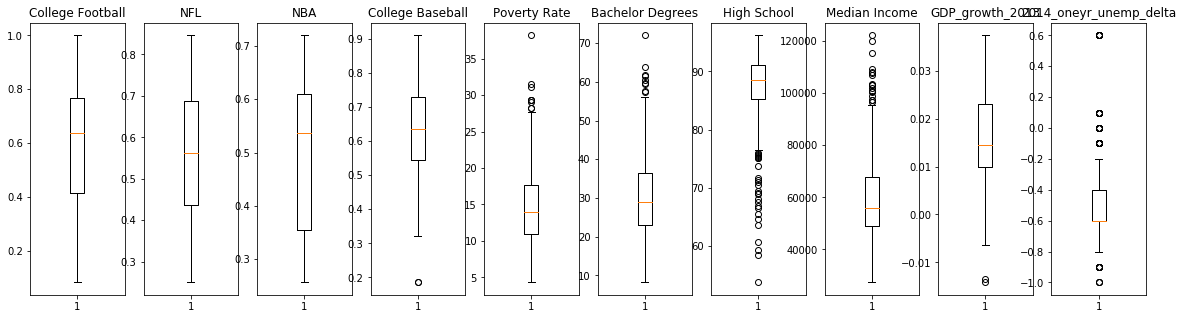

In [38]:
# boxplot for each feature 

fig, ax = plt.subplots(1,10, figsize=(20, 5))
ax[0].boxplot(model_frame18_dist['cfb 18'])
ax[1].boxplot(model_frame18_dist['nfl 18'])
ax[2].boxplot(model_frame18_dist['nba 18'])
ax[3].boxplot(model_frame18_dist['cbb 18'])
ax[4].boxplot(model_frame18_dist['poverty18'])
ax[5].boxplot(model_frame18_dist['bachelors18'])
ax[6].boxplot(model_frame18_dist['hs18'])
ax[7].boxplot(model_frame18_dist['med_inc18'])
ax[8].boxplot(model_frame18_dist['GDP_growth_2017'])
ax[9].boxplot(model_frame18_dist['2018_oneyr_unemp_delta'])


stats = ['College Football', 'NFL', 'NBA', 'College Baseball', 'Poverty Rate', 'Bachelor Degrees', 'High School', 'Median Income', 'GDP_growth_2013', '2014_oneyr_unemp_delta']
for i in range(10):
    ax[i].set_title(stats[i])

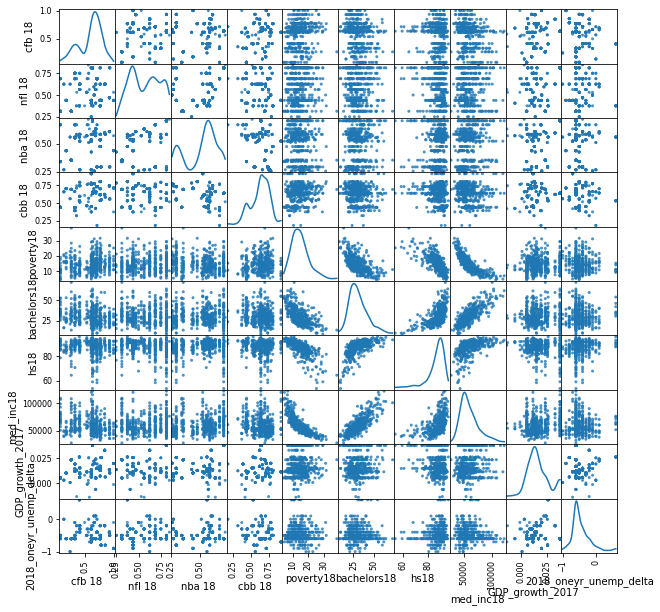

In [39]:
# Scatter Matrix 

to_scatter = ['cfb 18', 'nfl 18', 'nba 18', 'cbb 18', 'poverty18', 'bachelors18', 'hs18', 'med_inc18', 'GDP_growth_2017', '2018_oneyr_unemp_delta']

df_to_scatter = model_frame18_dist.loc[:,to_scatter]

from pandas.plotting import scatter_matrix
scatter_matrix(df_to_scatter, alpha=0.8, figsize=(10, 10), diagonal='kde');

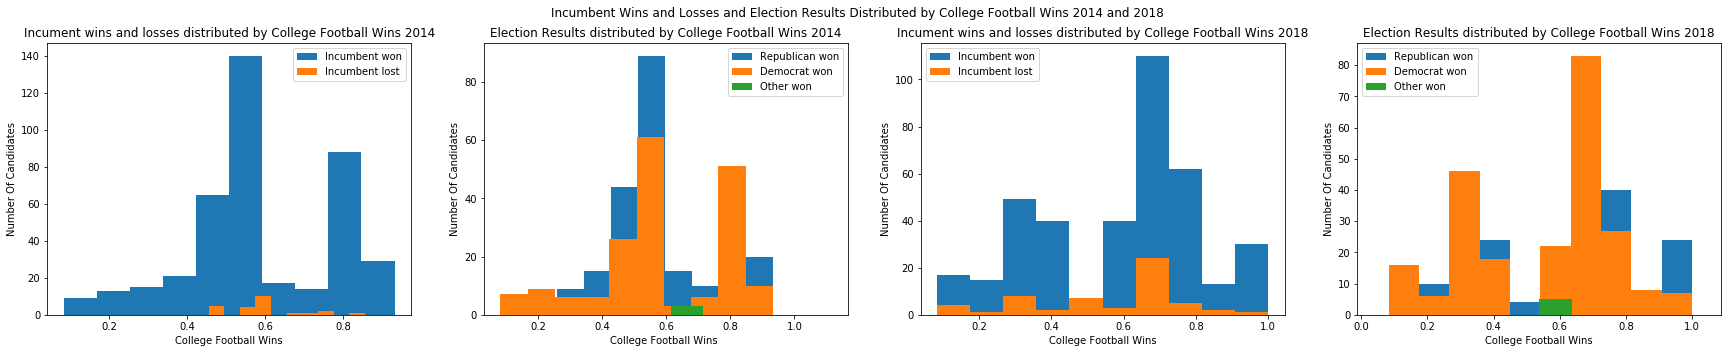

In [40]:
# Plot Incumbent Wins and Losses and Election Results Distributed by College Football Wins 2014 and 2018
fig, ax = plt.subplots(1,4, figsize=(30, 5))

fig.suptitle('Incumbent Wins and Losses and Election Results Distributed by College Football Wins 2014 and 2018')

ax[0].hist(incumbent_wins['cfb 14'], label='Incumbent won')
ax[0].hist(incumbent_loss['cfb 14'], label= 'Incumbent lost')
ax[0].set_xlabel('College Football Wins')
ax[0].set_ylabel('Number Of Candidates')
ax[0].set_title('Incument wins and losses distributed by College Football Wins 2014')
ax[0].legend()

ax[1].hist(republican['cfb 14'], label='Republican won')
ax[1].hist(democrat['cfb 14'], label= 'Democrat won')
ax[1].hist(other['cfb 14'], label= 'Other won')
ax[1].set_xlabel('College Football Wins ')
ax[1].set_ylabel('Number Of Candidates')
ax[1].set_title('Election Results distributed by College Football Wins 2014')
ax[1].legend()

ax[2].hist(incumbent_wins_18['cfb 18'], label='Incumbent won')
ax[2].hist(incumbent_loss_18['cfb 18'], label= 'Incumbent lost')
ax[2].set_xlabel('College Football Wins')
ax[2].set_ylabel('Number Of Candidates')
ax[2].set_title('Incument wins and losses distributed by College Football Wins 2018')
ax[2].legend()

ax[3].hist(republican_18['cfb 18'], label='Republican won')
ax[3].hist(democrat_18['cfb 18'], label= 'Democrat won')
ax[3].hist(other_18['cfb 18'], label= 'Other won')
ax[3].set_xlabel('College Football Wins')
ax[3].set_ylabel('Number Of Candidates')
ax[3].set_title('Election Results distributed by College Football Wins 2018')
ax[3].legend()


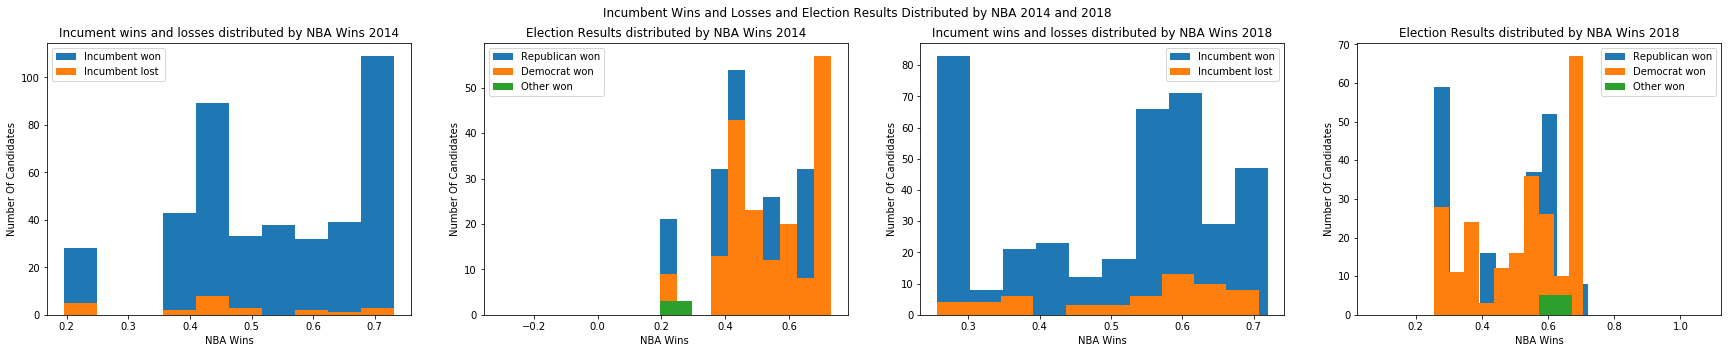

In [41]:
# Plot Incumbent Wins and Losses and Election Results Distributed by NBA 2014 and 2018
fig, ax = plt.subplots(1,4, figsize=(30, 5))

fig.suptitle('Incumbent Wins and Losses and Election Results Distributed by NBA 2014 and 2018')

ax[0].hist(incumbent_wins['nba 14'], label='Incumbent won')
ax[0].hist(incumbent_loss['nba 14'], label= 'Incumbent lost')
ax[0].set_xlabel('NBA Wins')
ax[0].set_ylabel('Number Of Candidates')
ax[0].set_title('Incument wins and losses distributed by NBA Wins 2014')
ax[0].legend()

ax[1].hist(republican['nba 14'], label='Republican won')
ax[1].hist(democrat['nba 14'], label= 'Democrat won')
ax[1].hist(other['nba 14'], label= 'Other won')
ax[1].set_xlabel('NBA Wins ')
ax[1].set_ylabel('Number Of Candidates')
ax[1].set_title('Election Results distributed by NBA Wins 2014')
ax[1].legend()

ax[2].hist(incumbent_wins_18['nba 18'], label='Incumbent won')
ax[2].hist(incumbent_loss_18['nba 18'], label= 'Incumbent lost')
ax[2].set_xlabel('NBA Wins')
ax[2].set_ylabel('Number Of Candidates')
ax[2].set_title('Incument wins and losses distributed by NBA Wins 2018')
ax[2].legend()

ax[3].hist(republican_18['nba 18'], label='Republican won')
ax[3].hist(democrat_18['nba 18'], label= 'Democrat won')
ax[3].hist(other_18['nba 18'], label= 'Other won')
ax[3].set_xlabel('NBA Wins')
ax[3].set_ylabel('Number Of Candidates')
ax[3].set_title('Election Results distributed by NBA Wins 2018')
ax[3].legend()

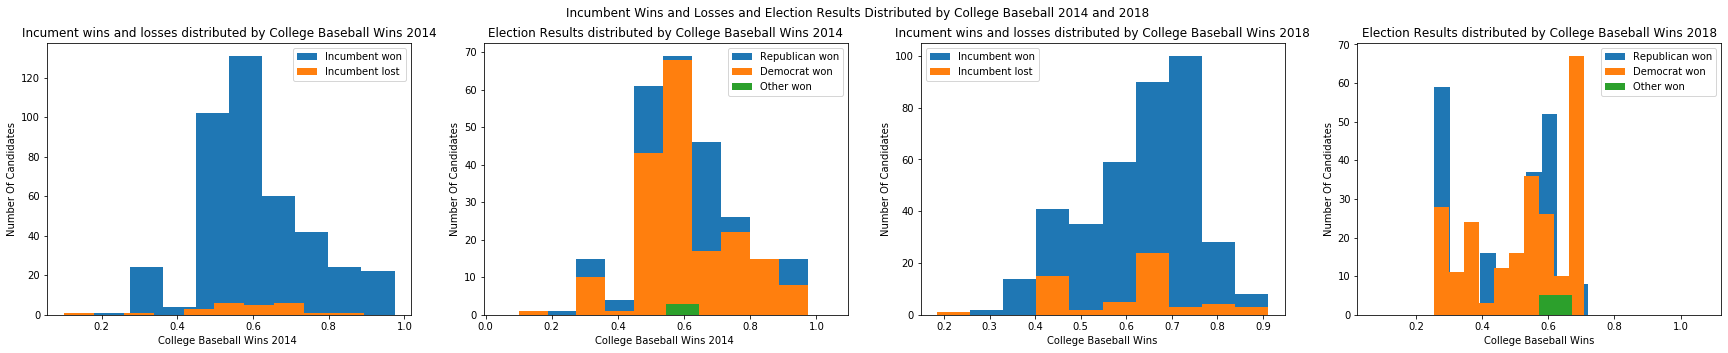

In [42]:
# Plot Incumbent Wins and Losses and Election Results Distributed by College Baseball 2014 and 2018
fig, ax = plt.subplots(1,4, figsize=(30, 5))

fig.suptitle('Incumbent Wins and Losses and Election Results Distributed by College Baseball 2014 and 2018')

ax[0].hist(incumbent_wins['cbb 14'], label='Incumbent won')
ax[0].hist(incumbent_loss['cbb 14'], label= 'Incumbent lost')
ax[0].set_xlabel('College Baseball Wins 2014 ')
ax[0].set_ylabel('Number Of Candidates')
ax[0].set_title('Incument wins and losses distributed by College Baseball Wins 2014')
ax[0].legend()

ax[1].hist(republican['cbb 14'], label='Republican won')
ax[1].hist(democrat['cbb 14'], label= 'Democrat won')
ax[1].hist(other['cbb 14'], label= 'Other won')
ax[1].set_xlabel('College Baseball Wins 2014 ')
ax[1].set_ylabel('Number Of Candidates')
ax[1].set_title('Election Results distributed by College Baseball Wins 2014')
ax[1].legend()

ax[2].hist(incumbent_wins_18['cbb 18'], label='Incumbent won')
ax[2].hist(incumbent_loss_18['cbb 18'], label= 'Incumbent lost')
ax[2].set_xlabel('College Baseball Wins')
ax[2].set_ylabel('Number Of Candidates')
ax[2].set_title('Incument wins and losses distributed by College Baseball Wins 2018')
ax[2].legend()

ax[3].hist(republican_18['nba 18'], label='Republican won')
ax[3].hist(democrat_18['nba 18'], label= 'Democrat won')
ax[3].hist(other_18['nba 18'], label= 'Other won')
ax[3].set_xlabel('College Baseball Wins')
ax[3].set_ylabel('Number Of Candidates')
ax[3].set_title('Election Results distributed by College Baseball Wins 2018')
ax[3].legend()

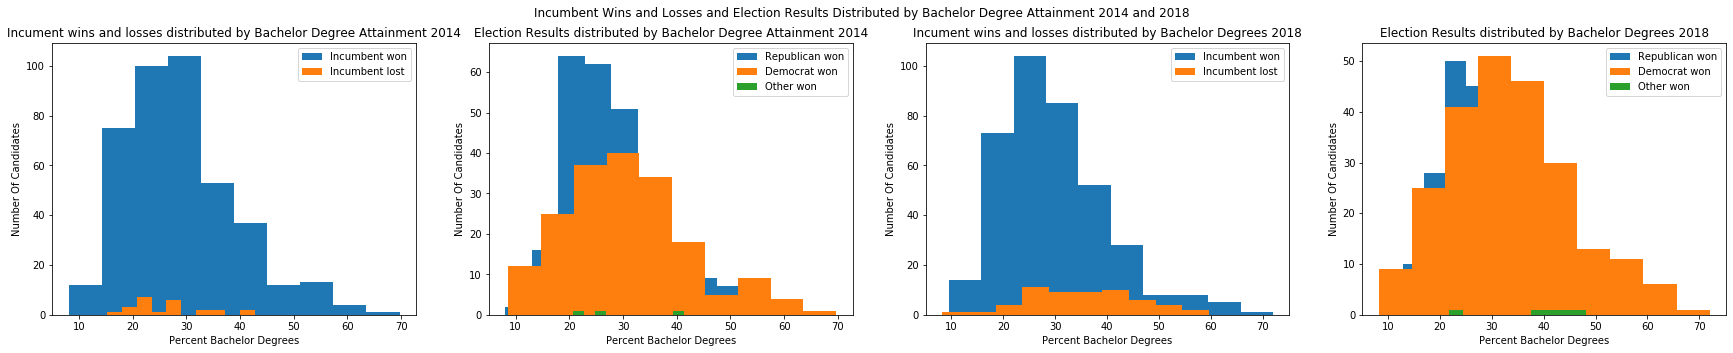

In [43]:
# Plot Incumbent Wins and Losses and Election Results Distributed by Bachelor Degree Attainment 2014 and 2018
fig, ax = plt.subplots(1,4, figsize=(30, 5))

fig.suptitle('Incumbent Wins and Losses and Election Results Distributed by Bachelor Degree Attainment 2014 and 2018')

ax[0].hist(incumbent_wins['bachelors14'], label='Incumbent won')
ax[0].hist(incumbent_loss['bachelors14'], label= 'Incumbent lost')
ax[0].set_xlabel('Percent Bachelor Degrees')
ax[0].set_ylabel('Number Of Candidates')
ax[0].set_title('Incument wins and losses distributed by Bachelor Degree Attainment 2014')
ax[0].legend()

ax[1].hist(republican['bachelors14'], label='Republican won')
ax[1].hist(democrat['bachelors14'], label= 'Democrat won')
ax[1].hist(other['bachelors14'], label= 'Other won')
ax[1].set_xlabel('Percent Bachelor Degrees')
ax[1].set_ylabel('Number Of Candidates')
ax[1].set_title('Election Results distributed by Bachelor Degree Attainment 2014')
ax[1].legend()

ax[2].hist(incumbent_wins_18['bachelors18'], label='Incumbent won')
ax[2].hist(incumbent_loss_18['bachelors18'], label= 'Incumbent lost')
ax[2].set_xlabel('Percent Bachelor Degrees')
ax[2].set_ylabel('Number Of Candidates')
ax[2].set_title('Incument wins and losses distributed by Bachelor Degrees 2018')
ax[2].legend()

ax[3].hist(republican_18['bachelors18'], label='Republican won')
ax[3].hist(democrat_18['bachelors18'], label= 'Democrat won')
ax[3].hist(other_18['bachelors18'], label= 'Other won')
ax[3].set_xlabel('Percent Bachelor Degrees')
ax[3].set_ylabel('Number Of Candidates')
ax[3].set_title('Election Results distributed by Bachelor Degrees 2018')
ax[3].legend()

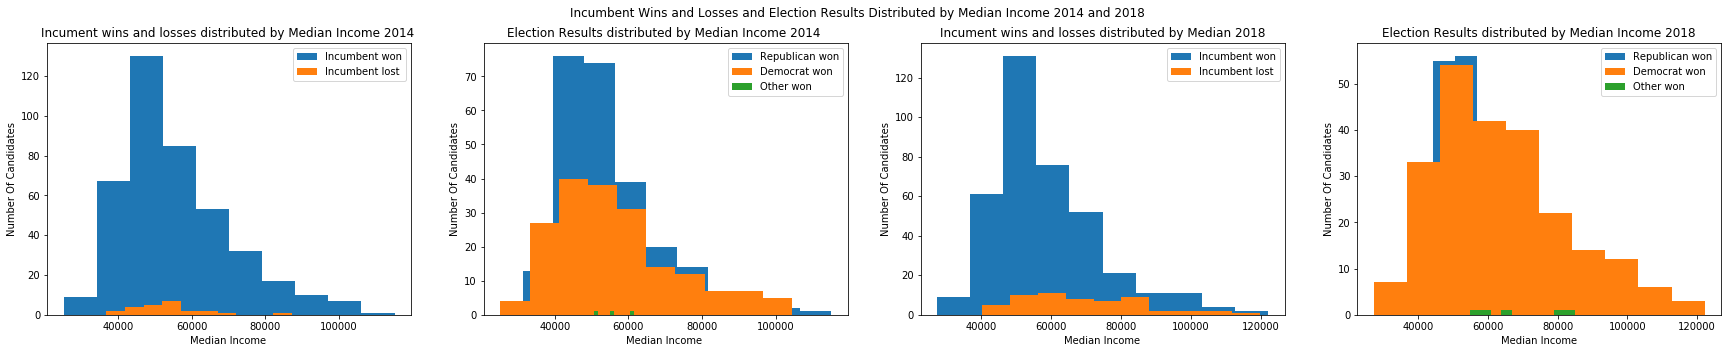

In [44]:
# Plot Incumbent Wins and Losses and Election Results Distributed by Median Income 2014 and 2018
fig, ax = plt.subplots(1,4, figsize=(30, 5))

fig.suptitle('Incumbent Wins and Losses and Election Results Distributed by Median Income 2014 and 2018')

ax[0].hist(incumbent_wins['med_inc14'], label='Incumbent won')
ax[0].hist(incumbent_loss['med_inc14'], label= 'Incumbent lost')
ax[0].set_xlabel('Median Income ')
ax[0].set_ylabel('Number Of Candidates')
ax[0].set_title('Incument wins and losses distributed by Median Income 2014 ')
ax[0].legend()

ax[1].hist(republican['med_inc14'], label='Republican won')
ax[1].hist(democrat['med_inc14'], label= 'Democrat won')
ax[1].hist(other['med_inc14'], label= 'Other won')
ax[1].set_xlabel('Median Income ')
ax[1].set_ylabel('Number Of Candidates')
ax[1].set_title('Election Results distributed by Median Income 2014 ')
ax[1].legend()

ax[2].hist(incumbent_wins_18['med_inc18'], label='Incumbent won')
ax[2].hist(incumbent_loss_18['med_inc18'], label= 'Incumbent lost')
ax[2].set_xlabel('Median Income')
ax[2].set_ylabel('Number Of Candidates')
ax[2].set_title('Incument wins and losses distributed by Median 2018')
ax[2].legend()

ax[3].hist(republican_18['med_inc18'], label='Republican won')
ax[3].hist(democrat_18['med_inc18'], label= 'Democrat won')
ax[3].hist(other_18['med_inc18'], label= 'Other won')
ax[3].set_xlabel('Median Income')
ax[3].set_ylabel('Number Of Candidates')
ax[3].set_title('Election Results distributed by Median Income 2018')
ax[3].legend()

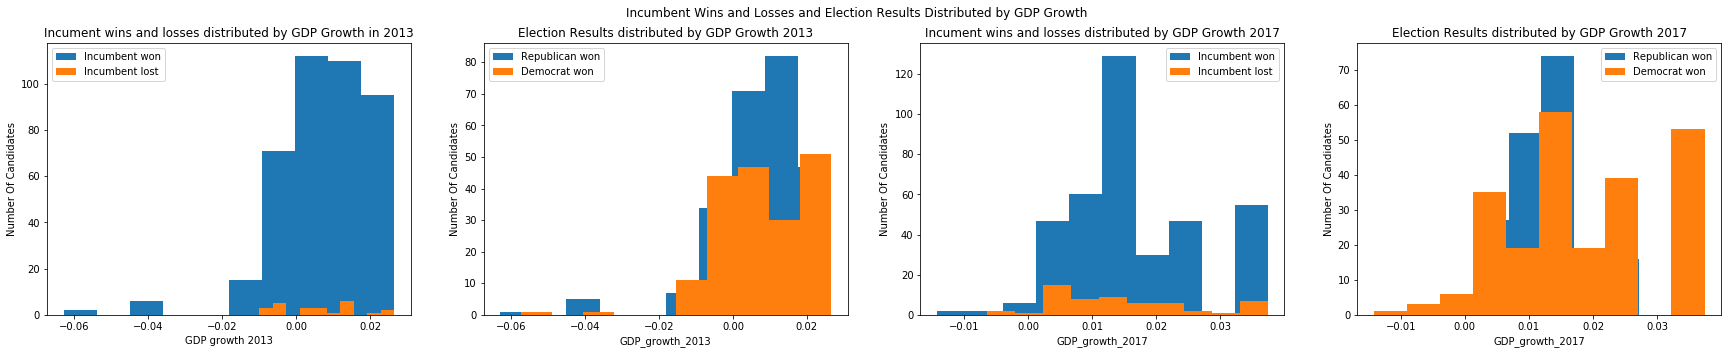

In [45]:
# Plot Incumbent Wins and Losses and Election Results Distributed by GDP Growth
fig, ax = plt.subplots(1,4, figsize=(30, 5))

fig.suptitle('Incumbent Wins and Losses and Election Results Distributed by GDP Growth')

ax[0].hist(incumbent_wins['GDP_growth_2013'], label='Incumbent won')
ax[0].hist(incumbent_loss['GDP_growth_2013'], label= 'Incumbent lost')
ax[0].set_xlabel('GDP growth 2013')
ax[0].set_ylabel('Number Of Candidates')
ax[0].set_title('Incument wins and losses distributed by GDP Growth in 2013')
ax[0].legend()

ax[1].hist(republican['GDP_growth_2013'], label='Republican won')
ax[1].hist(democrat['GDP_growth_2013'], label= 'Democrat won')
# ax[1].hist(other['GDP_growth_2013'], label= 'Other won')
ax[1].set_xlabel('GDP_growth_2013')
ax[1].set_ylabel('Number Of Candidates')
ax[1].set_title('Election Results distributed by GDP Growth 2013')
ax[1].legend()

ax[2].hist(incumbent_wins_18['GDP_growth_2017'], label='Incumbent won')
ax[2].hist(incumbent_loss_18['GDP_growth_2017'], label= 'Incumbent lost')
ax[2].set_xlabel('GDP_growth_2017')
ax[2].set_ylabel('Number Of Candidates')
ax[2].set_title('Incument wins and losses distributed by GDP Growth 2017')
ax[2].legend()

ax[3].hist(republican_18['GDP_growth_2017'], label='Republican won')
ax[3].hist(democrat_18['GDP_growth_2017'], label= 'Democrat won')
# ax[3].hist(other_18['GDP_growth_2017'], label= 'Other won')
ax[3].set_xlabel('GDP_growth_2017')
ax[3].set_ylabel('Number Of Candidates')
ax[3].set_title('Election Results distributed by GDP Growth 2017')
ax[3].legend()



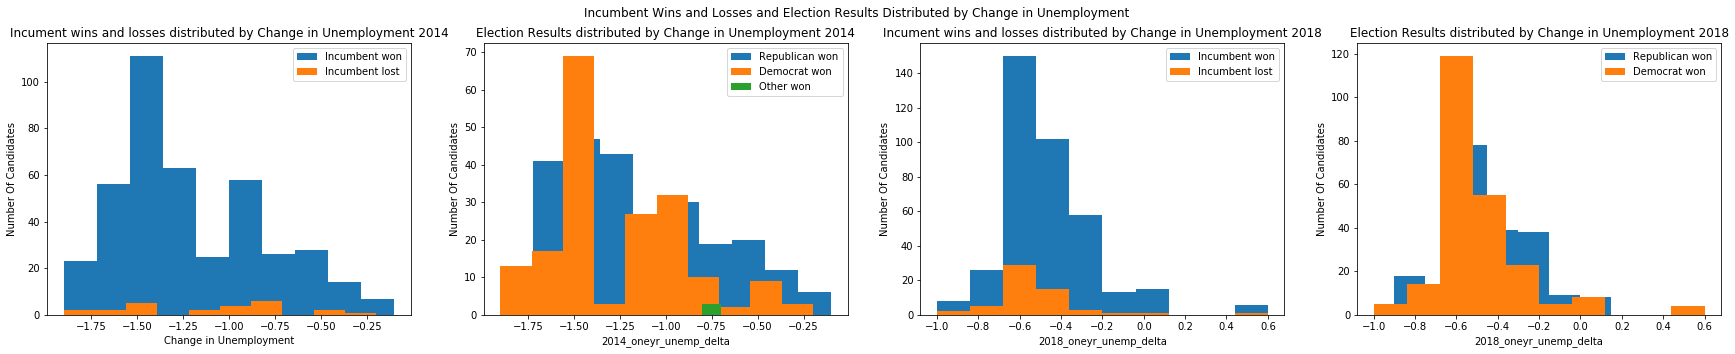

In [46]:
# Plot Incumbent Wins and Losses and Election Results Distributed by Change in Unemployment
fig, ax = plt.subplots(1,4, figsize=(30, 5))

fig.suptitle('Incumbent Wins and Losses and Election Results Distributed by Change in Unemployment')

to_scatter = ['cfb 14', 'nfl 14', 'nba 14', 'cbb 14', 'Percent poverty rate', 'Percent bachelor degrees', 'Percent high school', 'Median Income', 'GDP_growth_2013', '2014_oneyr_unemp_delta']
ax[0].hist(incumbent_wins['2014_oneyr_unemp_delta'], label='Incumbent won')
ax[0].hist(incumbent_loss['2014_oneyr_unemp_delta'], label= 'Incumbent lost')
ax[0].set_xlabel('Change in Unemployment')
ax[0].set_ylabel('Number Of Candidates')
ax[0].set_title('Incument wins and losses distributed by Change in Unemployment 2014')
ax[0].legend()

ax[1].hist(republican['2014_oneyr_unemp_delta'], label='Republican won')
ax[1].hist(democrat['2014_oneyr_unemp_delta'], label= 'Democrat won')
ax[1].hist(other['2014_oneyr_unemp_delta'], label= 'Other won')
ax[1].set_xlabel('2014_oneyr_unemp_delta')
ax[1].set_ylabel('Number Of Candidates')
ax[1].set_title('Election Results distributed by Change in Unemployment 2014')
ax[1].legend()

ax[2].hist(incumbent_wins_18['2018_oneyr_unemp_delta'], label='Incumbent won')
ax[2].hist(incumbent_loss_18['2018_oneyr_unemp_delta'], label= 'Incumbent lost')
ax[2].set_xlabel('2018_oneyr_unemp_delta')
ax[2].set_ylabel('Number Of Candidates')
ax[2].set_title('Incument wins and losses distributed by Change in Unemployment 2018')
ax[2].legend()

ax[3].hist(republican_18['2018_oneyr_unemp_delta'], label='Republican won')
ax[3].hist(democrat_18['2018_oneyr_unemp_delta'], label= 'Democrat won')
# ax[3].hist(other_18['GDP_growth_2017'], label= 'Other won')
ax[3].set_xlabel('2018_oneyr_unemp_delta')
ax[3].set_ylabel('Number Of Candidates')
ax[3].set_title('Election Results distributed by Change in Unemployment 2018')
ax[3].legend()


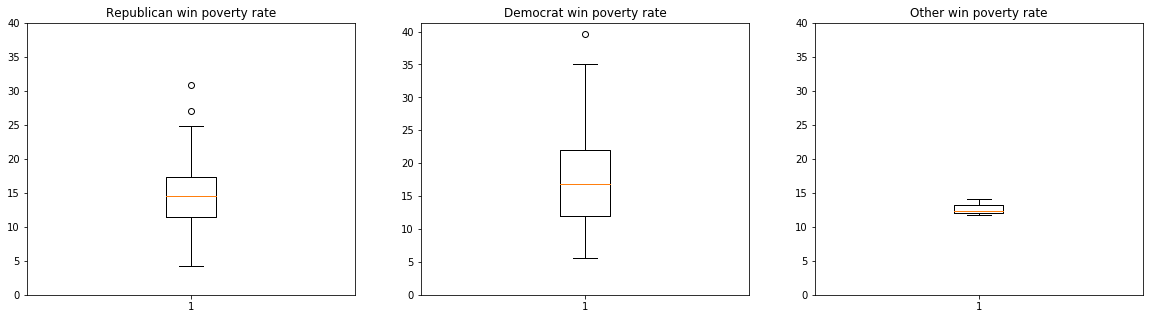

In [47]:
# Boxplot of party poverty rates
fig, ax = plt.subplots(1,3, figsize=(20, 5))
ax[0].boxplot(republican['poverty14'])
ax[0].set_title('Republican win poverty rate')
ax[1].boxplot(democrat['poverty14'])
ax[1].set_title('Democrat win poverty rate')
ax[2].boxplot(other['poverty14'])
ax[2].set_title('Other win poverty rate')
ax[0].set_yticks(np.arange(0, 45, step=5))
ax[1].set_yticks(np.arange(0, 45, step=5))
ax[2].set_yticks(np.arange(0, 45, step=5))

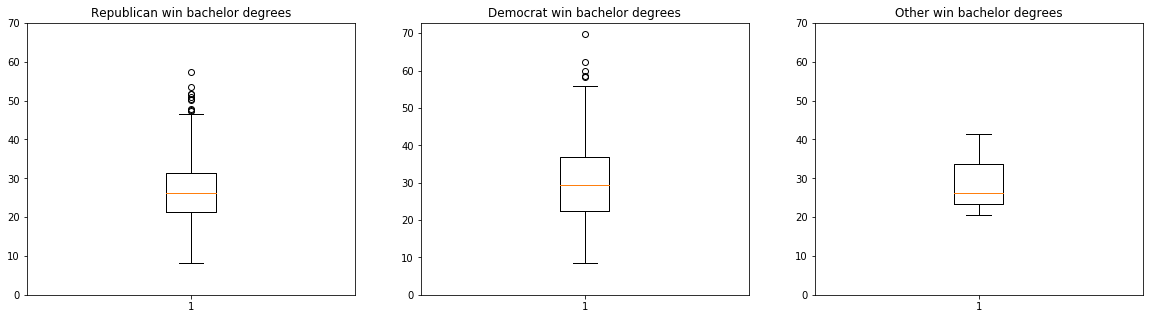

In [48]:
# Plot party bachelor degree rates
fig, ax = plt.subplots(1,3, figsize=(20, 5))
ax[0].boxplot(republican['bachelors14'])
ax[0].set_title('Republican win bachelor degrees')
ax[1].boxplot(democrat['bachelors14'])
ax[1].set_title('Democrat win bachelor degrees')
ax[2].boxplot(other['bachelors14'])
ax[2].set_title('Other win bachelor degrees')
ax[0].set_yticks(np.arange(0, 71, step=10))
ax[1].set_yticks(np.arange(0, 71, step=10))
ax[2].set_yticks(np.arange(0, 71, step=10))

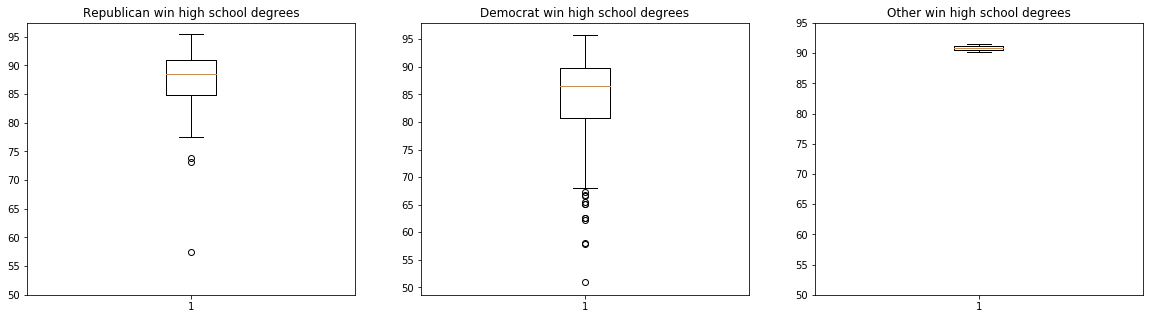

In [49]:
# Plot party high school degree rates
fig, ax = plt.subplots(1,3, figsize=(20, 5))
ax[0].boxplot(republican['hs14'])
ax[0].set_title('Republican win high school degrees')
ax[1].boxplot(democrat['hs14'])
ax[1].set_title('Democrat win high school degrees')
ax[2].boxplot(other['hs14'])
ax[2].set_title('Other win high school degrees')
ax[0].set_yticks(np.arange(50, 100, step=5))
ax[1].set_yticks(np.arange(50, 100, step=5))
ax[2].set_yticks(np.arange(50, 100, step=5))

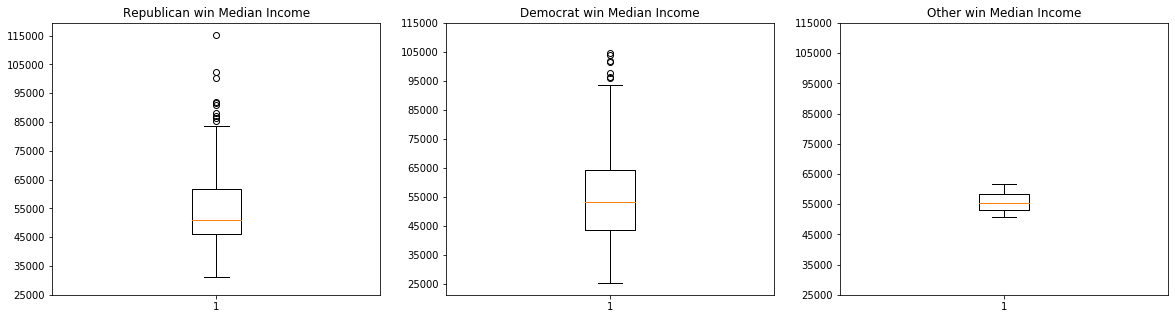

In [50]:
# Plot median income by party
fig, ax = plt.subplots(1,3, figsize=(20, 5))
ax[0].boxplot(republican['med_inc14'])
ax[0].set_title('Republican win Median Income')
ax[1].boxplot(democrat['med_inc14'])
ax[1].set_title('Democrat win Median Income')
ax[2].boxplot(other['med_inc14'])
ax[2].set_title('Other win Median Income')
ax[0].set_yticks(np.arange(25000, 120000, step=10000))
ax[1].set_yticks(np.arange(25000, 120000, step=10000))
ax[2].set_yticks(np.arange(25000, 120000, step=10000))

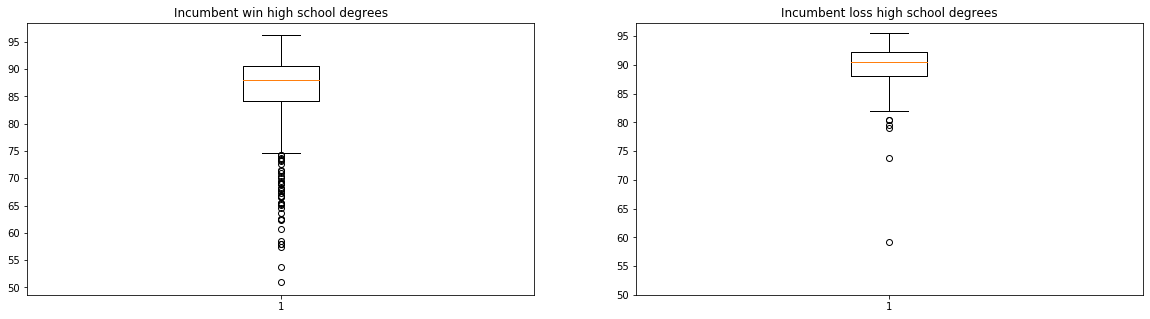

In [51]:
# Plot high school degree rates for elections won or lost by incumbents
all_inc_wins_hs = np.concatenate((incumbent_wins['hs14'].values,incumbent_wins_18['hs18'].values), axis=None)
all_inc_loss_hs = np.concatenate((incumbent_loss['hs14'].values,incumbent_loss_18['hs18'].values), axis=None)
fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].boxplot(all_inc_wins_hs)
ax[0].set_title('Incumbent win high school degrees')
ax[1].boxplot(all_inc_loss_hs)
ax[1].set_title('Incumbent loss high school degrees')
ax[0].set_yticks(np.arange(50, 100, step=5))
ax[1].set_yticks(np.arange(50, 100, step=5))

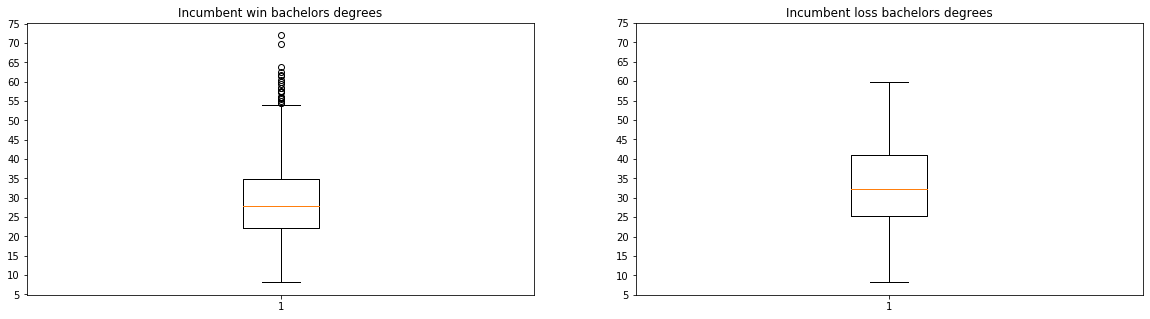

In [52]:
# Plot bachelor degree rates for elections won or lost by incumbents
all_inc_wins_bach = np.concatenate((incumbent_wins['bachelors14'].values,incumbent_wins_18['bachelors18'].values), axis=None)
all_inc_loss_bach = np.concatenate((incumbent_loss['bachelors14'].values,incumbent_loss_18['bachelors18'].values), axis=None)
fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].boxplot(all_inc_wins_bach)
ax[0].set_title('Incumbent win bachelors degrees')
ax[1].boxplot(all_inc_loss_bach)
ax[1].set_title('Incumbent loss bachelors degrees')
ax[0].set_yticks(np.arange(5, 80, step=5))
ax[1].set_yticks(np.arange(5, 80, step=5))

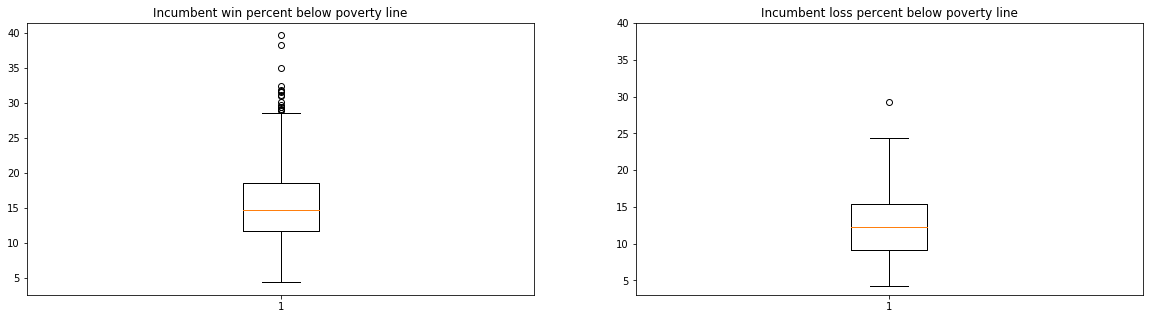

In [53]:
# Plot poverty rates for elections won or lost by incumbents
all_inc_wins_pov = np.concatenate((incumbent_wins['poverty14'].values,incumbent_wins_18['poverty18'].values), axis=None)
all_inc_loss_pov = np.concatenate((incumbent_loss['poverty14'].values,incumbent_loss_18['poverty18'].values), axis=None)
fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].boxplot(all_inc_wins_pov)
ax[0].set_title('Incumbent win percent below poverty line')
ax[1].boxplot(all_inc_loss_pov)
ax[1].set_title('Incumbent loss percent below poverty line')
ax[0].set_yticks(np.arange(5, 45, step=5))
ax[1].set_yticks(np.arange(5, 45, step=5))

# Create the Train and Test Frames

In [54]:
# Create 2014 scaled dataframes
model_frame14_st_xs = model_frame14_st.drop(columns = ['class','cfb 14', 'nfl 14', 'nba 14','cbb 14',
                                                          'poverty14', 'bachelors14', 'hs14', '2011_GDP',
                                                          '2012_GDP', '2013_GDP', '2014_oneyr_unemp_delta', 
                                                          'GDP_growth_2013','district','state_po', 'state_district', 'inc_win'])

model_frame14_y = model_frame14_dist['class']

model_frame14_dist_xs = model_frame14_dist.drop(columns = ['class','cfb 14', 'nfl 14', 'nba 14','cbb 14',
                                                          'poverty14', 'bachelors14', 'hs14', '2011_GDP',
                                                          '2012_GDP', '2013_GDP', '2014_oneyr_unemp_delta', 
                                                          'GDP_growth_2013','district','state_po', 'state_district', 'inc_win'])

# Create 2018 scaled dataframes
model_frame18_dist_xs = model_frame18_dist.drop(columns = ['class','cfb 18', 'nfl 18', 'nba 18','cbb 18',
                                                      'poverty18', 'bachelors18', 'hs18', '2015_GDP',
                                                      '2016_GDP', '2017_GDP', '2018_oneyr_unemp_delta', 
                                                      'GDP_growth_2017','district', 'state_po', 'state_district', 'inc_win'])

model_frame18_y = model_frame18_dist['class']

model_frame18_st_xs = model_frame18_st.drop(columns = ['class','cfb 18', 'nfl 18', 'nba 18','cbb 18',
                                                      'poverty18', 'bachelors18', 'hs18', '2015_GDP',
                                                      '2016_GDP', '2017_GDP', '2018_oneyr_unemp_delta', 
                                                      'GDP_growth_2017','district', 'state_po', 'state_district', 'inc_win'])


In [55]:
# Create 2014 scaled dataframes without incumbency
model_frame14_dist_xs_noinc = model_frame14_dist_xs.drop(columns = ['incumbency', 'same'])

model_frame14_st_xs_noinc = model_frame14_st_xs.drop(columns = ['incumbency', 'same'])

# Create 2018 scaled dataframes without incumbency
model_frame18_st_xs_noinc = model_frame18_st_xs.drop(columns = ['incumbency', 'same'])


model_frame18_dist_xs_noinc = model_frame18_dist_xs.drop(columns = ['incumbency', 'same'])


# Modeling Explorations

In [56]:
def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

## Models with Incumbency

### KNN Classifier

In [57]:
# Using cross validation to compare KNN scores for 
ks = [1,2,3,4,5,7,9,10,15,25,50,100,200]

knn_cv_scores = []

for k in ks:
    model = KNeighborsClassifier(n_neighbors=k).fit(model_frame14_st_xs, model_frame14_y)
    
    scores = cross_val_score(model,model_frame14_st_xs, model_frame14_y, cv=3)
    
    knn_cv_scores.append((k,np.mean(scores)))
    
print(knn_cv_scores)

print('\nThe best score appears to be 100, so we will look at a confusiong matrix for that \n')

knn_model = KNeighborsClassifier(n_neighbors=100).fit(model_frame14_st_xs, model_frame14_y)

print("Knn-model: \n "+ str(confusion_matrix(model_frame18_y,t_repredict(knn_model,0.5,model_frame18_st_xs))))

print("\nKnn-model test accuracy: " + str(accuracy_score(t_repredict(knn_model,i,model_frame18_st_xs), model_frame18_y)))

[(1, 0.6875557654962473), (2, 0.6736351668153747), (3, 0.673603457023391), (4, 0.6712884235203554), (5, 0.6713039503840165), (7, 0.6850810895921903), (9, 0.7099719641701219), (10, 0.7031069035497471), (15, 0.6959730751062825), (25, 0.6875511730436151), (50, 0.671474089819626), (100, 0.8022780751937577), (200, 0.6921178204657185)]

The best score appears to be 100, so we will look at a confusiong matrix for that 

Knn-model: 
 [[180  17   0]
 [121 112   0]
 [  5   0   0]]

Knn-model test accuracy: 0.4528735632183908


The best cutoff point provides an accuracy score of: 0.7011494252873564


Text(0, 0.5, 'Test Accuracy Percentage')

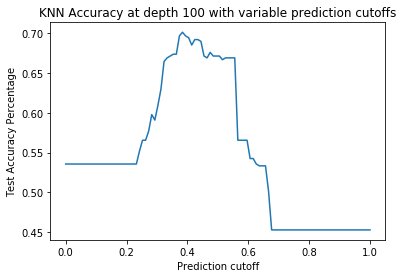

In [58]:
scores = []
for i in np.linspace(0,1,100):
    scores.append(accuracy_score(t_repredict(knn_model,i,model_frame18_st_xs), model_frame18_y))

print("The best cutoff point provides an accuracy score of: " + str(max(scores)))

plt.plot(np.linspace(0,1,100), scores)
plt.title('KNN Accuracy at depth 100 with variable prediction cutoffs')
plt.xlabel('Prediction cutoff')
plt.ylabel('Test Accuracy Percentage')

From the initial confusion matrix it is clear that the model will initially over heavily over predict republican candidate, however with the adjustments to the cutoff point the model is actually able to perform noticeably better than the default cutoff. Interestingly this model doesn't focus too significantly on incumbancy and doesn't overfit to this predictor.

### Decision Tree Classifier

Text(0, 0.5, 'Test Accuracy Percentage')

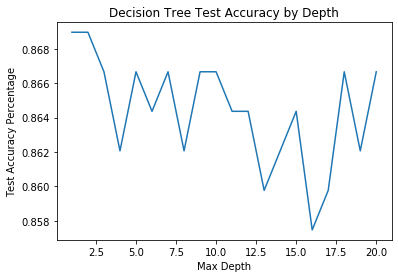

In [59]:
depths = np.linspace(1,20,num=20)
cvmeans = []
test_scores = []

for i in depths:
    model = DecisionTreeClassifier(max_depth = i)
    score = cross_val_score(estimator=model, X=model_frame14_st_xs, y=model_frame14_y, cv=3)
    cvmeans.append(score.mean())
    test_scores.append(accuracy_score(model.fit(model_frame14_st_xs, model_frame14_y).predict(model_frame18_st_xs), model_frame18_y))

test_scores

plt.plot(depths, test_scores)
plt.title('Decision Tree Test Accuracy by Depth')
plt.xlabel('Max Depth')
plt.ylabel('Test Accuracy Percentage')

From these scores, it is clear that the decision tree is focusing heavily on incumbency and as a result the predictions are centering right around and slightly below the true incumbency success rate of the 2018 election.

### Random Forest Classifier

Random Forest Train ST Score: 0.9471264367816092
Random Forest Test ST Score: 0.8689655172413793
-------
Random Forest Train DIST Score: 0.967816091954023
Random Forest Test DIST Score: 0.8367816091954023


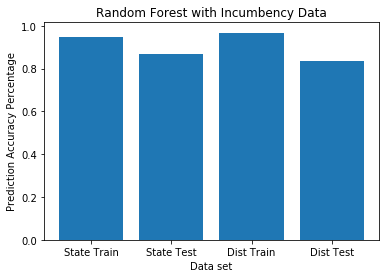

In [60]:
###### State
random_forest_st = RandomForestClassifier(max_features = 10, max_depth=1, n_estimators = 50)
random_forest_st.fit(model_frame14_st_xs, model_frame14_y)

random_forest_train14_pred_st = random_forest_st.predict(model_frame14_st_xs)
random_forest_test18_pred_st = random_forest_st.predict(model_frame18_st_xs)

random_forest_train14_score_st = accuracy_score(model_frame14_y, random_forest_train14_pred_st)
random_forest_test18_score_st = accuracy_score(model_frame18_y, random_forest_test18_pred_st)

####### District
random_forest_dist = RandomForestClassifier(max_features = 10, max_depth=5, n_estimators = 700)
random_forest_dist.fit(model_frame14_dist_xs, model_frame14_y)

random_forest_train14_pred_dist = random_forest_dist.predict(model_frame14_dist_xs)
random_forest_test18_pred_dist = random_forest_dist.predict(model_frame18_dist_xs)

random_forest_train14_score_dist = accuracy_score(model_frame14_y, random_forest_train14_pred_dist)
random_forest_test18_score_dist = accuracy_score(model_frame18_y, random_forest_test18_pred_dist)

print("Random Forest Train ST Score: " + str(random_forest_train14_score_st))
print("Random Forest Test ST Score: " + str(random_forest_test18_score_st))
print("-------")
print("Random Forest Train DIST Score: " + str(random_forest_train14_score_dist))
print("Random Forest Test DIST Score: " + str(random_forest_test18_score_dist))

plt.bar(['State Train', 'State Test', 'Dist Train', 'Dist Test'],[random_forest_train14_score_st,random_forest_test18_score_st,random_forest_train14_score_dist,random_forest_test18_score_dist])
plt.title('Random Forest with Incumbency Data')
plt.xlabel('Data set')
plt.ylabel('Prediction Accuracy Percentage')
plt.show()

This model also tends to heavily overfit the data even with a low maximum depth it still has a tendancy towards over reliance on incumbency especially in the state aggregated data.

### Logistic Regression

In [61]:
# Logistic Regression on district level data 
logregcv = LogisticRegressionCV(cv = 3, solver = 'liblinear', penalty = 'l1')
logregcv.fit(model_frame14_dist_xs, model_frame14_y)
dist_predict = logregcv.predict(model_frame18_dist_xs)
dist_acc = accuracy_score(dist_predict, model_frame18_y)
print("Logisitc regressions with CV district level accuracy: ", str(accuracy_score(dist_predict, model_frame18_y)))

# Logistic Regression on state level data 
logregcv_st = LogisticRegressionCV(cv = 3, solver = 'liblinear', penalty = 'l1', max_iter=1000)
logregcv_st.fit(model_frame14_st_xs, model_frame14_y)
st_predict = logregcv_st.predict(model_frame18_st_xs)
st_acc = accuracy_score(st_predict, model_frame18_y)
print("Logisitc regressions with CV state level accuracy: ", str(accuracy_score(st_predict, model_frame18_y)))


/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Logisitc regressions with CV district level accuracy:  0.7609195402298851


/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logisitc regressions with CV state level accuracy:  0.8689655172413793


This model is also highly prone to overfitting to the incumbency data.

### No Incumbency Models

The goal with these models was to see how different classifiers would perform when incumbency data is not known

#### Decision Tree

In [62]:
depths = np.linspace(1,20,num=20)
cvmeans = []
test_scores = []

for i in depths:
    model = DecisionTreeClassifier(max_depth = i)
    score = cross_val_score(estimator=model, X=model_frame14_st_xs_noinc, y=model_frame14_y, cv=3)
    cvmeans.append(score.mean())
    test_scores.append(accuracy_score(model.fit(model_frame14_st_xs_noinc, model_frame14_y).predict(model_frame18_st_xs_noinc), model_frame18_y))

for i in depths:
    print(str(int(i)) + " : " + str(test_scores[int(i-1)]))

1 : 0.7310344827586207
2 : 0.6528735632183909
3 : 0.7241379310344828
4 : 0.6528735632183909
5 : 0.6988505747126437
6 : 0.6528735632183909
7 : 0.6436781609195402
8 : 0.7011494252873564
9 : 0.6919540229885057
10 : 0.6528735632183909
11 : 0.6459770114942529
12 : 0.696551724137931
13 : 0.6988505747126437
14 : 0.6528735632183909
15 : 0.6528735632183909
16 : 0.6758620689655173
17 : 0.696551724137931
18 : 0.6459770114942529
19 : 0.6551724137931034
20 : 0.7011494252873564


These trees do not perform especially well, implying that there is not a significant ability for this model to create strong predictions from weaker predictors.

#### Logistic Regression

In [63]:
# Logistic Regression on district level data 
logregcv_noinc = LogisticRegressionCV(cv = 3, solver = 'liblinear', penalty = 'l1', max_iter=1000)
logregcv_noinc.fit(model_frame14_dist_xs_noinc, model_frame14_y)
dist_predict_noinc = logregcv_noinc.predict(model_frame18_dist_xs_noinc)
dist_acc_noinc = accuracy_score(dist_predict_noinc, model_frame18_y)
print("Logisitc regressions with CV district level no incumbency accuracy: ", str(accuracy_score(dist_predict_noinc, model_frame18_y)))

# Logistic Regression on state level data 
logregcv_st_noinc = LogisticRegressionCV(cv = 3, solver = 'liblinear', penalty = 'l1', max_iter=1000)
logregcv_st_noinc.fit(model_frame14_st_xs_noinc, model_frame14_y)
st_predict_noinc = logregcv_st_noinc.predict(model_frame18_st_xs_noinc)
st_acc_noinc = accuracy_score(st_predict_noinc, model_frame18_y)
print("Logisitc regressions with CV state level no incumbency accuracy: ", str(accuracy_score(st_predict_noinc, model_frame18_y)))


/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logisitc regressions with CV district level no incumbency accuracy:  0.7586206896551724


/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logisitc regressions with CV state level no incumbency accuracy:  0.6988505747126437


These regressions appear to perform noticeably when given district level data, and even just the simple regression 

#### Random Forest

Random Forest Train ST No Inc Score: 0.7241379310344828
Random Forest Test ST No Inc Score: 0.7126436781609196
-------
Random Forest Train DIST No Inc Score: 0.9011494252873563
Random Forest Test DIST No Inc Score: 0.7931034482758621


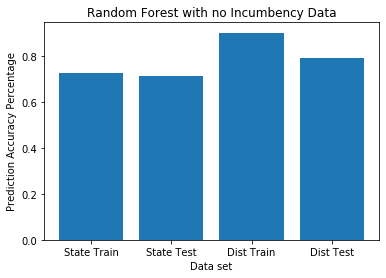

In [64]:
###### State
random_forest_st_noinc = RandomForestClassifier(max_features = 10, max_depth=5, n_estimators = 700)
random_forest_st_noinc.fit(model_frame14_st_xs_noinc, model_frame14_y)

random_forest_train14_pred_st_noinc = random_forest_st_noinc.predict(model_frame14_st_xs_noinc)
random_forest_test18_pred_st_noinc = random_forest_st_noinc.predict(model_frame18_st_xs_noinc)

random_forest_train14_score_st_noinc = accuracy_score(model_frame14_y, random_forest_train14_pred_st_noinc)
random_forest_test18_score_st_noinc = accuracy_score(model_frame18_y, random_forest_test18_pred_st_noinc)

####### District
random_forest_dist_noinc = RandomForestClassifier(max_features = 10, max_depth=5, n_estimators = 700)
random_forest_dist_noinc.fit(model_frame14_dist_xs_noinc, model_frame14_y)

random_forest_train14_pred_dist_noinc = random_forest_dist_noinc.predict(model_frame14_dist_xs_noinc)
random_forest_test18_pred_dist_noinc = random_forest_dist_noinc.predict(model_frame18_dist_xs_noinc)

random_forest_train14_score_dist_noinc = accuracy_score(model_frame14_y, random_forest_train14_pred_dist_noinc)
random_forest_test18_score_dist_noinc = accuracy_score(model_frame18_y, random_forest_test18_pred_dist_noinc)

print("Random Forest Train ST No Inc Score: " + str(random_forest_train14_score_st_noinc))
print("Random Forest Test ST No Inc Score: " + str(random_forest_test18_score_st_noinc))
print("-------")
print("Random Forest Train DIST No Inc Score: " + str(random_forest_train14_score_dist_noinc))
print("Random Forest Test DIST No Inc Score: " + str(random_forest_test18_score_dist_noinc))

plt.bar(['State Train', 'State Test', 'Dist Train', 'Dist Test'],[random_forest_train14_score_st_noinc,random_forest_test18_score_st_noinc,random_forest_train14_score_dist_noinc,random_forest_test18_score_dist_noinc])
plt.title('Random Forest with no Incumbency Data')
plt.xlabel('Data set')
plt.ylabel('Prediction Accuracy Percentage')
plt.show()



### Hybrid Model

This model was an attempt at creating predictions from the non-incumbany data and then combining those predictions with incumbancy data to attempt to get a more impactful model

#### Hybrid Logistic

In [65]:
# District 
new14 = pd.DataFrame()
new14['preds'] = dist_predict_noinc
new14['inc'] = model_frame14_dist_xs['incumbency'].values
new14['same'] = model_frame14_dist_xs['same'].values

preds18 = logregcv_noinc.predict(model_frame18_dist_xs.drop(columns = ['incumbency', 'same'], axis=1))
new18 = pd.DataFrame()
new18['preds'] = preds18
new18['inc'] = model_frame18_dist_xs['incumbency'].values
new18['same'] = model_frame18_dist_xs['same'].values

logregcvhyb = LogisticRegressionCV(cv = 3, solver = 'liblinear', penalty = 'l1')
logregcvhyb.fit(new14, model_frame14_y)
predict_hyb = logregcvhyb.predict(new18)
hybrid_acc = accuracy_score(dist_predict_noinc, model_frame18_y)
print("Logisitc regressions with CV and district data accuracy: ", str(accuracy_score(predict_hyb, model_frame18_y)))

#State 
new14_st = pd.DataFrame()
new14_st['preds'] = st_predict_noinc
new14_st['inc'] = model_frame14_st_xs['incumbency'].values
new14_st['same'] = model_frame14_st_xs['same'].values

preds18_st = logregcv_st_noinc.predict(model_frame18_st_xs.drop(columns = ['incumbency', 'same'], axis=1))
new18_st = pd.DataFrame()
new18_st['preds'] = preds18_st
new18_st['inc'] = model_frame18_st_xs['incumbency'].values
new18_st['same'] = model_frame18_st_xs['same'].values

logregcvhyb_st = LogisticRegressionCV(cv = 3, solver = 'liblinear', penalty = 'l1')
logregcvhyb_st.fit(new14_st, model_frame14_y)
predict_hyb_st = logregcvhyb.predict(new18_st)
hybrid_acc_st = accuracy_score(dist_predict_noinc, model_frame18_y)
print("Logisitc regressions with CV and state data accuracy: ", str(hybrid_acc_st))

/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Logisitc regressions with CV and district data accuracy:  0.8689655172413793


/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/envs/tfcs109a/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Logisitc regressions with CV and state data accuracy:  0.7586206896551724


## Predicting Incumbent Success

In addition to these attempts at modeling party outcomes for elections, we tried some models which attempted to predict simply if the incumbent party won or lost.

In [66]:
# Create new dataframes for the models predicting the success of an incumbent
incumbent_predictor14_xs = model_frame14_dist.drop(columns = ['cfb 14', 'nfl 14', 'nba 14','cbb 14',
                                                          'poverty14', 'bachelors14', 'hs14', '2011_GDP',
                                                          '2012_GDP', '2013_GDP', '2014_oneyr_unemp_delta', 
                                                          'GDP_growth_2013','district','state_po', 'state_district', 'incumbency','inc_win', 'class'])

incumbent_predictor14_y = model_frame14_st['inc_win']

incumbent_predictor18_xs = model_frame18_dist.drop(columns = ['cfb 18', 'nfl 18', 'nba 18','cbb 18',
                                                          'poverty18', 'bachelors18', 'hs18', '2016_GDP',
                                                          '2017_GDP', '2015_GDP', '2018_oneyr_unemp_delta', 
                                                          'GDP_growth_2017','district','state_po', 'state_district', 'incumbency', 'inc_win', 'class'])

incumbent_predictor18_y = model_frame18_st['inc_win']

### Random Forest

In [67]:
inc_random_forest_model = RandomForestClassifier(max_features = 10, max_depth=1, n_estimators = 1)
inc_random_forest_model.fit(incumbent_predictor14_xs, incumbent_predictor18_y)

inc_random_forest_train_predictions = inc_random_forest_model.predict(incumbent_predictor14_xs)
inc_random_forest_test_predictions = inc_random_forest_model.predict(incumbent_predictor18_xs)

inc_random_forest_train_score = accuracy_score(incumbent_predictor14_y, inc_random_forest_train_predictions)
inc_random_forest_test_score = accuracy_score(incumbent_predictor18_y, inc_random_forest_test_predictions)

print("Random Forest Train Score: " + str(inc_random_forest_train_score))
print("Random Forest Test Score: " + str(inc_random_forest_test_score))

print("Random Forest: \n "+ str(confusion_matrix(incumbent_predictor18_y, inc_random_forest_test_predictions)))

Random Forest Train Score: 0.8919540229885058
Random Forest Test Score: 0.8528735632183908
Random Forest: 
 [[  1  56]
 [  8 370]]


#### Additional hybrid model
In addition to the above model, a hybrid using the outcomes of this and some incumbency information was attempted. This model also severly overfit to the incumbency values.

In [68]:
new14 = pd.DataFrame()
new14['preds'] = inc_random_forest_train_predictions
new14['inc'] = model_frame14_st_xs['incumbency'].values
new14['same'] = incumbent_predictor14_xs['same'].values

new18 = pd.DataFrame()
new18['preds'] = inc_random_forest_test_predictions
new18['inc'] = model_frame18_st_xs['incumbency'].values
new18['same'] = incumbent_predictor18_xs['same'].values


In [69]:
multi_logit = LogisticRegressionCV(cv=3,solver='liblinear',penalty = 'l1', max_iter = 10000)

multi_logit.fit(new14, incumbent_predictor14_y.values)

y_pred = multi_logit.predict(new18)
print("Hybrid accuracy score: " + str(accuracy_score(incumbent_predictor18_y, y_pred.round())))


Hybrid accuracy score: 0.8689655172413793


# Final Model: ADABoost

In [70]:
###### State
ADABoost_st = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 5,max_features =13, criterion ='entropy'),learning_rate = 0.01 ,n_estimators = 55)
ADABoost_st.fit(model_frame14_st_xs, model_frame14_y)

ADABoost_train14_pred_st = ADABoost_st.predict(model_frame14_st_xs)
ADABoost_test18_pred_st = ADABoost_st.predict(model_frame18_st_xs)

ADABoost_train14_score_st = accuracy_score(model_frame14_y, random_forest_train14_pred_st)
ADABoost_test18_score_st = accuracy_score(model_frame18_y, random_forest_test18_pred_st)

####### District
ADABoost_dist = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 5,max_features= 13, criterion ='entropy'),learning_rate = 0.01,n_estimators = 755)
ADABoost_dist.fit(model_frame14_dist_xs, model_frame14_y)

ADABoost_train14_pred_dist = ADABoost_dist.predict(model_frame14_dist_xs)
ADABoost_test18_pred_dist = ADABoost_dist.predict(model_frame18_dist_xs)

ADABoost_train14_score_dist = accuracy_score(model_frame14_y, ADABoost_train14_pred_dist)
ADABoost_test18_score_dist = accuracy_score(model_frame18_y, ADABoost_test18_pred_dist)

print("ADABoost Train ST Score: " + str(ADABoost_train14_score_st))
print("ADABoost Test ST Score: " + str(ADABoost_test18_score_st))
print("-------")
print("ADABoost Train DIST Score: " + str(ADABoost_train14_score_dist))
print("ADABoost Test DIST Score: " + str(ADABoost_test18_score_dist))

ADABoost Train ST Score: 0.9471264367816092
ADABoost Test ST Score: 0.8689655172413793
-------
ADABoost Train DIST Score: 1.0
ADABoost Test DIST Score: 0.7034482758620689


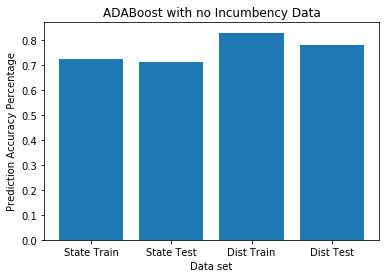

ADABoost Train ST No Inc Score: 0.7241379310344828
ADABoost Test ST No Inc Score: 0.7126436781609196
-------
ADABoost Train DIST No Inc Score: 0.8298850574712644
ADABoost Test DIST No Inc Score: 0.7816091954022989
-------
ADABoost Train14 Dist CM:
 [[199  48   0]
 [ 26 159   0]
 [  0   0   3]]
ADABoost Test18 Dist CM:
 [[161  36   0]
 [ 54 179   0]
 [  0   5   0]]


In [71]:
###### State
ADABoost_st_noinc = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 5,max_features =13, criterion ='entropy')
                                       ,learning_rate = 0.01 ,n_estimators = 55)
ADABoost_st_noinc.fit(model_frame14_st_xs_noinc, model_frame14_y)

ADABoost_train14_pred_st_noinc = ADABoost_st_noinc.predict(model_frame14_st_xs_noinc)
ADABoost_test18_pred_st_noinc = ADABoost_st_noinc.predict(model_frame18_st_xs_noinc)

ADABoost_train14_score_st_noinc = accuracy_score(model_frame14_y, random_forest_train14_pred_st_noinc)
ADABoost_test18_score_st_noinc = accuracy_score(model_frame18_y, random_forest_test18_pred_st_noinc)

####### District
ADABoost_dist_noinc = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3,max_features= 12, criterion ='entropy')
                                         ,learning_rate = 0.055,n_estimators = 10)
ADABoost_dist_noinc.fit(model_frame14_dist_xs_noinc, model_frame14_y)

ADABoost_train14_pred_dist_noinc = ADABoost_dist_noinc.predict(model_frame14_dist_xs_noinc)
ADABoost_test18_pred_dist_noinc = ADABoost_dist_noinc.predict(model_frame18_dist_xs_noinc)

ADABoost_train14_score_dist_noinc = accuracy_score(model_frame14_y, ADABoost_train14_pred_dist_noinc)
ADABoost_test18_score_dist_noinc = accuracy_score(model_frame18_y, ADABoost_test18_pred_dist_noinc)

ADABoost_CM_train14_dist_noinc = confusion_matrix(model_frame14_y, ADABoost_train14_pred_dist_noinc)
ADABoost_CM_test18_dist18_noinc = confusion_matrix(model_frame18_y, ADABoost_test18_pred_dist_noinc)


plt.bar(['State Train', 'State Test', 'Dist Train', 'Dist Test'],[ADABoost_train14_score_st_noinc,ADABoost_test18_score_st_noinc,ADABoost_train14_score_dist_noinc,ADABoost_test18_score_dist_noinc])
plt.title('ADABoost with no Incumbency Data')
plt.xlabel('Data set')
plt.ylabel('Prediction Accuracy Percentage')
plt.show()

print("ADABoost Train ST No Inc Score: " + str(ADABoost_train14_score_st_noinc))
print("ADABoost Test ST No Inc Score: " + str(ADABoost_test18_score_st_noinc))
print("-------")
print("ADABoost Train DIST No Inc Score: " + str(ADABoost_train14_score_dist_noinc))
print("ADABoost Test DIST No Inc Score: " + str(ADABoost_test18_score_dist_noinc))
print("-------")
print("ADABoost Train14 Dist CM:\n", ADABoost_CM_train14_dist_noinc)
print("ADABoost Test18 Dist CM:\n", ADABoost_CM_test18_dist18_noinc)


In [72]:
x = 1
print("Feature Importances")
for i in ADABoost_dist_noinc.feature_importances_:
    print(x, " : ", i)
    x+=1
x = 1
print("Feature Names")
for i in model_frame14_dist_xs_noinc:
    print(x, " : ", i)
    x+=1

Feature Importances
1  :  0.27856760142261244
2  :  0.0
3  :  0.03581087755434598
4  :  0.007085118656453279
5  :  0.02112313035940533
6  :  0.13371670077441022
7  :  0.006443289710581878
8  :  0.23984039019602563
9  :  0.0645827102700859
10  :  0.06950432532813991
11  :  0.07904640723269948
12  :  0.03583261700823363
13  :  0.0
14  :  0.0
15  :  0.028446831487006257
Feature Names
1  :  pres_class
2  :  pres
3  :  med_inc14
4  :  cfb 14scaled
5  :  nfl 14scaled
6  :  nba 14scaled
7  :  cbb 14scaled
8  :  poverty14scaled
9  :  bachelors14scaled
10  :  hs14scaled
11  :  2012_GDPscaled
12  :  2013_GDPscaled
13  :  2014_oneyr_unemp_deltascaled
14  :  GDP_growth_2013scaled
15  :  med_inc14scaled


This model performed tremendously well even with the incumbency information withheld. Interestingly, one of the most important features was pres_class, which represents whether or not the state voted for the current president in the previous election. Also very interesing are the importances of NBA, poverty, and high school diploma rates. While this is not to say that any one of these features definitively explains the election results, they do point to the importance of social factors in these elections.

### ADABoost Hybrid Extension

In [73]:
new14st = pd.DataFrame()
new14st['preds'] = ADABoost_train14_pred_st_noinc
new14st['inc'] = model_frame14_st['incumbency'].values

new14dist = pd.DataFrame()
new14dist['preds'] = ADABoost_train14_pred_dist_noinc
new14dist['inc'] = model_frame14_dist['incumbency'].values

new18st = pd.DataFrame()
new18st['preds'] = ADABoost_test18_pred_st_noinc
new18st['inc'] = model_frame18_st['incumbency'].values

new18dist = pd.DataFrame()
new18dist['preds'] = ADABoost_test18_pred_dist_noinc
new18dist['inc'] = model_frame18_dist['incumbency'].values

## State
ADABoost_hybrid14_st = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3,max_features= 1, criterion ='entropy')
                                         ,learning_rate = 0.066,n_estimators = 10)
ADABoost_hybrid14_st.fit(new14st,model_frame14_y)
y_pred_14_st = ADABoost_hybrid14_st.predict(new14st)

#

ADABoost_hybrid18_st = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3,max_features= 1, criterion ='entropy')
                                         ,learning_rate = 0.066,n_estimators = 10)
ADABoost_hybrid18_st.fit(new14st,model_frame14_y)
y_pred_18_st = ADABoost_hybrid18_st.predict(new18st)


## District
ADABoost_hybrid14_dist = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 1,max_features= 1, criterion ='entropy')
                                         ,learning_rate = 0.0006,n_estimators = 1)
ADABoost_hybrid14_dist.fit(new14dist,model_frame14_y)
y_pred_14_dist = ADABoost_hybrid14_dist.predict(new14dist)

#

ADABoost_hybrid18_dist = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 1,max_features= 1, criterion ='entropy')
                                         ,learning_rate = 0.0006,n_estimators = 1)
ADABoost_hybrid18_dist.fit(new18dist,model_frame18_y)
y_pred_18_dist = ADABoost_hybrid18_dist.predict(new18dist)


ADABoost_hybrid_train14_st_score = accuracy_score(model_frame14_y, y_pred_14_st)
ADABoost_hybrid_test18_st_score = accuracy_score(model_frame18_y, y_pred_18_st)

ADABoost_hybrid_train14_dist_score = accuracy_score(model_frame14_y, y_pred_14_dist)
ADABoost_hybrid_test18_dist_score = accuracy_score(model_frame18_y, y_pred_18_dist)

ADABoost_CM_train_dist14 = confusion_matrix(model_frame14_y, y_pred_14_dist)
ADABoost_CM_test_dist18 = confusion_matrix(model_frame18_y, y_pred_18_dist)

print("ADABoost hybrid Train14 ST  Score: " + str(ADABoost_hybrid_train14_st_score))
print("ADABoost hybrid Test18 ST  Score: " + str(ADABoost_hybrid_test18_st_score))
print("-------")
print("ADABoost hybrid Train14 DIST  Score: " + str(ADABoost_hybrid_train14_dist_score))
print("ADABoost hybrid Test18 DIST  Score: " + str(ADABoost_hybrid_test18_dist_score))
print("-------")
print("ADABoost hybrid Train14  Dist CM:\n", ADABoost_CM_train_dist14)
print("ADABoost hybrid Test18 Dist CM:\n", ADABoost_CM_test_dist18)

ADABoost hybrid Train14 ST  Score: 0.9471264367816092
ADABoost hybrid Test18 ST  Score: 0.8689655172413793
-------
ADABoost hybrid Train14 DIST  Score: 0.8229885057471265
ADABoost hybrid Test18 DIST  Score: 0.8689655172413793
-------
ADABoost hybrid Train14  Dist CM:
 [[199  48   0]
 [ 26 159   0]
 [  0   3   0]]
ADABoost hybrid Test18 Dist CM:
 [[192   5   0]
 [ 47 186   0]
 [  2   3   0]]


This model, while less prone to overfitting than the previous model, does unquestionably have a tendency to overfit to incumbency as well and is therefore less usefull with regards to generalizability than the pure ADABoost model prior to it.